# Sentiment analysis

Sentiment analysis or opinion mining involves classifying comments or opinions in text into categories such as "positive" or "negative", often with an implicit category of "neutral".

## Importations

In [8]:
import json
import pandas as pd
import numpy as np
import re
from nltk.tokenize import TweetTokenizer
import string
import nltk.corpus
import matplotlib.pyplot as plt

## Tweets

We will begin with the sentiment analysis of the tweets that we collected.

### Data importation

In [9]:
# Define companies' names and its products names
entities = ['Nintendo', 'Playstation', 'Xbox', 'Engage', 'Forspoken', 'HFRush']

In [10]:
# Import clean tweets
tweets = {}
for entity in entities:
    path = f'Videojocs/cleanTweets/{entity}.csv'
    tweets[entity] = pd.read_csv(path)
    tweets[entity] = tweets[entity].dropna() # Drpo NaN values

### Pre-trained models

In [11]:
# Compound score function for VADER (not useful for ROBERTA)
def compound_score(scores, alfa=15, beta=1):
    x = float(np.sum(scores))
    return (x+beta)/(np.sqrt(x**2)+beta)

#### Twitter-roBERTa-base for Sentiment Analysis

We will use a specific model trained to analyze tweets: [roBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). The computations are slower, since it makes use of tensors to analyze text by text, extracting the percentage of sentiment present in it, so we have to apply them element by element. Its main drawback is that this model does not have a **compound score**, so we will decide the main sentiment based on the one that is more present during the analysis (each analyzed text have a percentage of sentiment detected).

Besides that, we have created a compound score based on the following formula:


$$f(pos,neu,neg) = 
     \begin{cases}
       \text{0,} &\quad\text{if neu > |pos - neg|}\\
       \frac{pos + neu - neg}{\sqrt{(pos + neu - neg)^2}}, &\quad\text{otherwise.} \\ 
     \end{cases}$$
     
Where pos, neu and neg are the not normalized positive, neutral and negative scores found in the text; respectively. Roughly speaking, each one of these scores that variates from -4 to 4, indicates how much of each sentiment is in the text. Thus, in case that neutral were the predominant sentiment, we give it a value of 0. Otherwise, we normalize the scores and see if the sentiment obtained is whether positive (1) or negative (-1).

In [12]:
def compound_score(scores):
    if (scores[1] > abs(-scores[0]+scores[2])):
        return 0
    else:
        return (-scores[0]+scores[1]+scores[2])/(np.sqrt((-scores[0]+scores[1]+scores[2])**2))

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from scipy.special import softmax

In [14]:
# Load RoBERTa model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [15]:
# Trial of the scores
for index, tweet in tweets['Engage'].iterrows():
    if index > 10:
        break
    print(tweet.lemmatizedText)
    inputs = tokenizer(tweet.lemmatizedText, return_tensors='pt')
    classification = model(**inputs)
    scores = classification[0][0].detach().numpy()
    print(scores)
    normScores = softmax(scores)
    print(normScores)
    compScore = compound_score(scores)
    print(compScore)

making progress finally let play fire emblem engage
[-3.4069092  1.1576403  2.1524656]
[0.00280364 0.26920322 0.7279932 ]
1.0
live playing fire emblem engage blind come check stream
[-1.9221586   2.1206007  -0.17163262]
[0.01568849 0.8939829  0.09032853]
0
fire emblem engage special vocal edition blu ray disc 02 08 07 58
[-1.4399008  2.2837722 -0.7900532]
[0.02255733 0.93423975 0.0432029 ]
0
recording podcast tonight think gonna stream fire emblem engage 10 pm
[-3.2990208  2.3700066  0.840706 ]
[0.00282855 0.8195791  0.17759229]
1.0
fire emblem engage till maybe ult
[-1.6150945   1.9464742  -0.28254172]
[0.02499431 0.8802596  0.09474614]
0
live fe engage paralogues story looking support grab tea relax nowi stream
[-2.8686335  1.7525787  1.0397851]
[0.00656008 0.66661626 0.3268237 ]
1.0
sound like muh censorship chuds wish fe engage localization handled better sense english voice direction make sound like 4kids dub
[ 0.76498765  0.7064929  -1.4635395 ]
[0.4875979  0.45989418 0.05250793]

In [ ]:
# Use the model on each tweet to perform sentiment analysis
for entity in entities:
    ROBERTAmaxSentiment = []
    ROBERTAcompSentiment = []
    for index, tweet in tweets[entity].iterrows():
        # Calculate sentiment of each tweet
        inputs = tokenizer(tweet.lemmatizedText, return_tensors='pt')
        classification = model(**inputs)
        scores = classification[0][0].detach().numpy()
        normScores = softmax(scores) # Normalized scored
        maxSentiment = np.argsort(normScores)[::-1][:1] # Decide sentiment based on predominant feeling (maximum)
        ROBERTAmaxSentiment.append(maxSentiment)
        compScore = compound_score(scores) # Decide sentiment based on compound scored
        ROBERTAcompSentiment.append(compScore)
    # Add sentiment classification to the df
    tweets[entity]['ROBERTAmaxSentiment'] = ROBERTAmaxSentiment
    tweets[entity]['ROBERTAcompSentiment'] = ROBERTAcompSentiment
    print(f'Sentiment calculated for {entity} tweets.')

##### Save labeled data

Due to the high volume of the data and the sentiment analysis with this model has to be performed element by element, we will store the labeled data so we can access it quicker if we execute the notebook in the future.

In [ ]:
for entity in entities:
    path = f'Videojocs/labeledSentiment/{entity}.csv'
    tweets[entity].to_csv(path, index=False)

##### Load labeled data

In [24]:
import re
for entity in entities:
    path = f'Videojocs/labeledSentiment/{entity}.csv'
    tweets[entity] = pd.read_csv(path)
    tweets[entity] = tweets[entity].dropna() # Drop NaN values
    tweets[entity]['ROBERTAmaxSentiment'] = tweets[entity]['ROBERTAmaxSentiment'].apply(lambda x: int(re.compile("'|\[|\]|'").sub('', x)))

After loading/saving the data, we can analyze the results obtained.

In [25]:
# Counters of positive, neutral and negative opinions; respectively
pos = {}
neu = {}
neg = {}
for entity in entities: # Initialize array that counts sentiment scores (dictionaries)
    pos[entity] = {}
    neu[entity] = {}
    neg[entity] = {}
scoreTypes = ['maxROBERTA', 'compoundROBERTA']
for entity in entities: # Add scores
    # Separate scores for positve(2), neutral(1) and negative(0)
    pos[entity]['maxROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAmaxSentiment == 2])
    neg[entity]['maxROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAmaxSentiment == 0])
    neu[entity]['maxROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAmaxSentiment == 1])
    # Seperate scores for positve(1), neutral(0) and negative(-1)
    pos[entity]['compoundROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAcompSentiment == 1.0])
    neg[entity]['compoundROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAcompSentiment == -1.0])
    neu[entity]['compoundROBERTA'] = len(tweets[entity][tweets[entity].ROBERTAcompSentiment == 0.0])

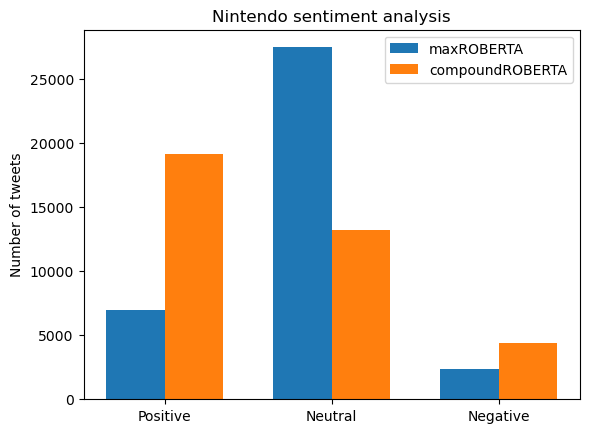

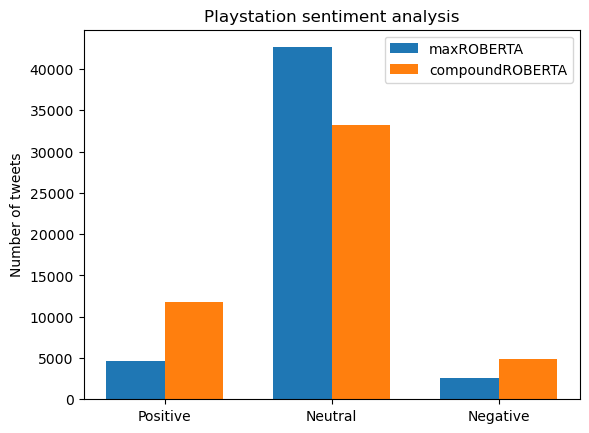

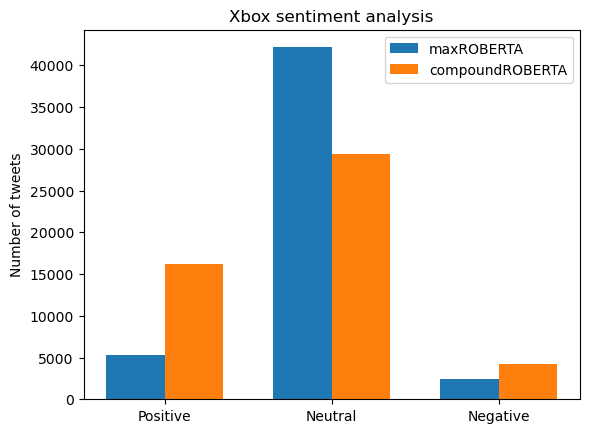

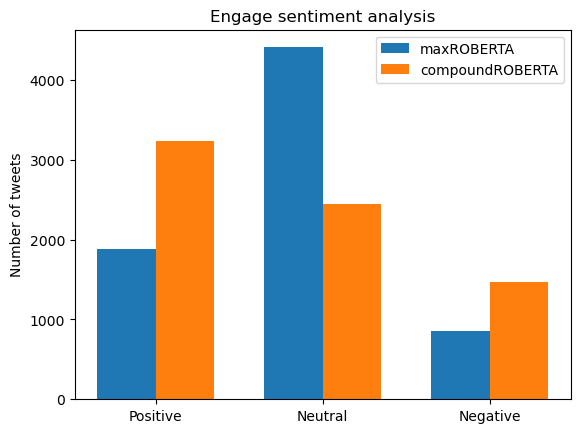

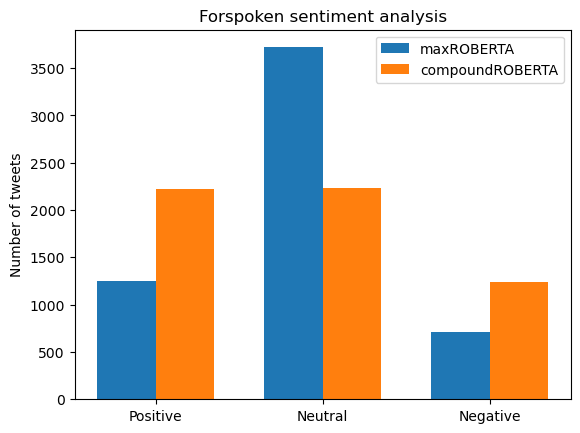

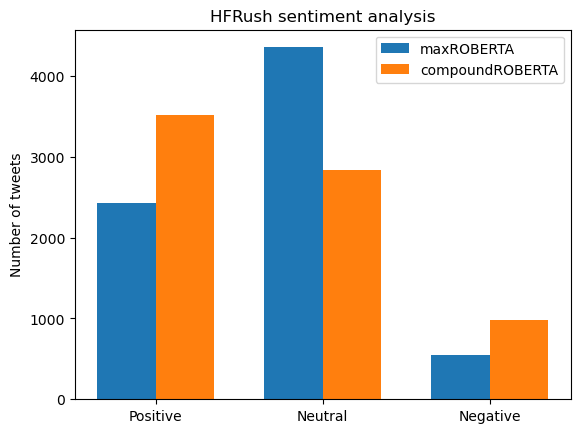

In [26]:
# Graph
index = np.arange(3)
bar_width = 0.35
for entity in entities:
    fig, ax = plt.subplots()
    i = 0
    for tipo in scoreTypes:
        y = [pos[entity][tipo], neu[entity][tipo], neg[entity][tipo]]
        subGrafico = ax.bar(index+bar_width*i, y, bar_width, label=f'{tipo}')
        i += 1
    #ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number of tweets')
    ax.set_title(f'{entity} sentiment analysis')
    ax.set_xticks(index + bar_width / i)
    ax.set_xticklabels(["Positive", "Neutral", "Negative"])
    ax.legend()
    plt.show()

#### VADER

[VADER](https://www.nltk.org/_modules/nltk/sentiment/vader.html) **(Valence Aware Dictionary and sEntiment Reasoner)** is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. Its main adavantage is that is very easy to use and compute. Besides, apart from the especific percentage of sentiment manifested in each tweet, it also gives us a so called **compound score** that let us classify it as positive, neutral or negative more accurately.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\barri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [28]:
sentiment = SentimentIntensityAnalyzer()

In [29]:
scoreTypes.append('VADER')
for entity in entities:
    tweets[entity]['VADERsentiment'] = tweets[entity].lemmatizedText.apply(lambda x: sentiment.polarity_scores(x)['compound'])
    pos[entity]['VADER'] = len(tweets[entity][tweets[entity].VADERsentiment > 0])
    neg[entity]['VADER'] = len(tweets[entity][tweets[entity].VADERsentiment < 0])
    neu[entity]['VADER'] = len(tweets[entity][tweets[entity].VADERsentiment == 0])

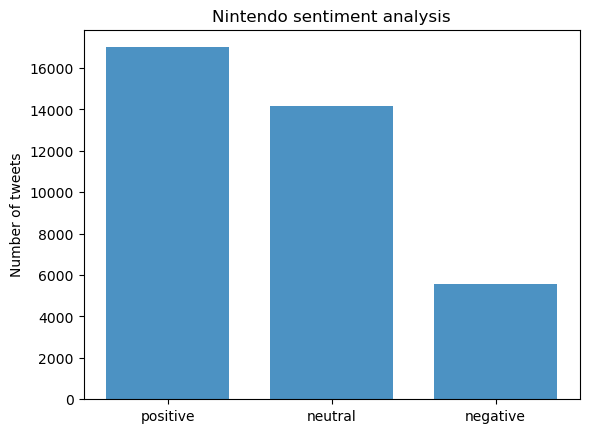

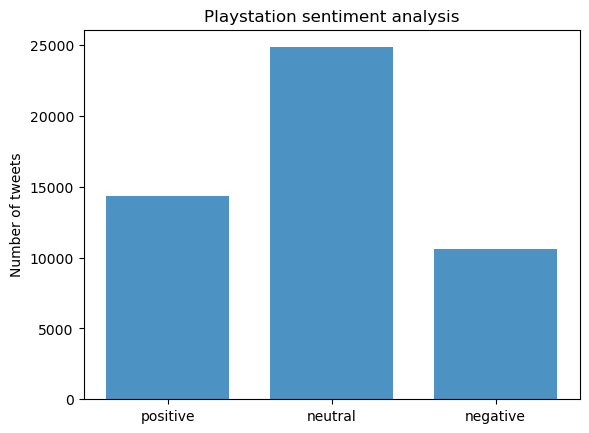

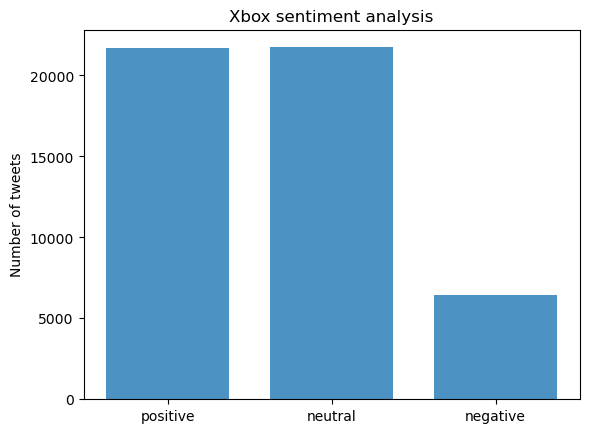

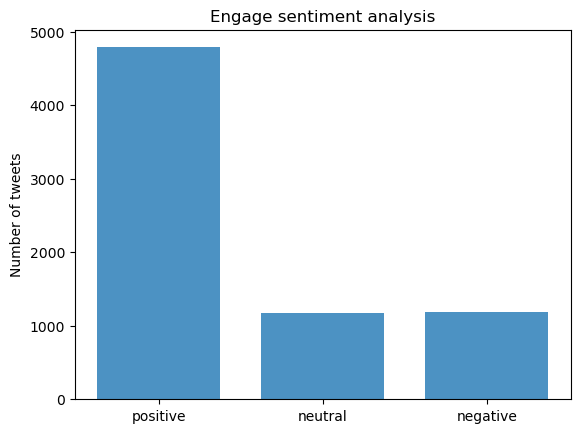

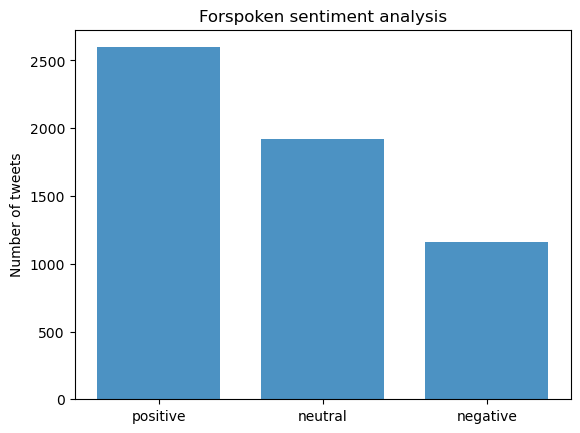

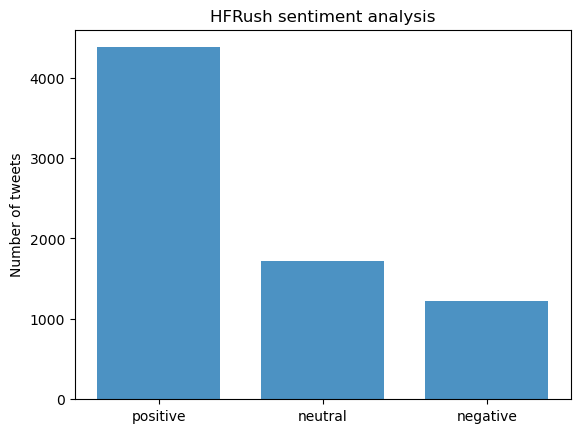

In [30]:
for entity in entities:
    y = [pos[entity]['VADER'], neu[entity]['VADER'], neg[entity]['VADER']]
    plt.title(f'{entity} sentiment analysis')
    plt.ylabel('Number of tweets')
    plt.xticks(range(len(y)), ['positive', 'neutral', 'negative'])
    plt.bar(range(len(y)), height=y, width = 0.75, align = 'center', alpha = 0.8)
    plt.show()

#### Graph comparison

Now we can compare the results obtained.

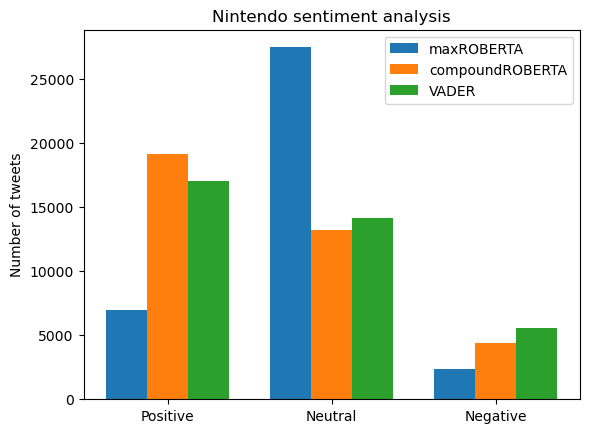

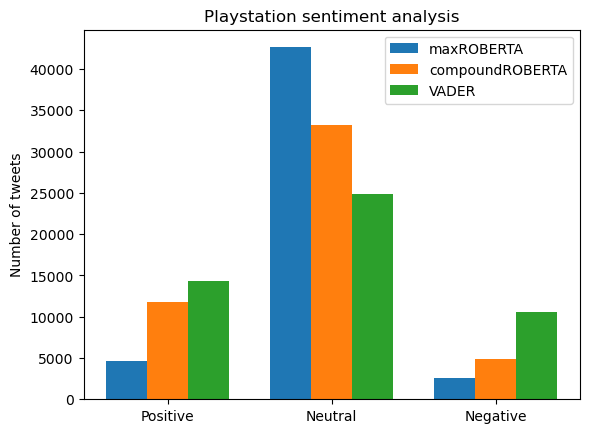

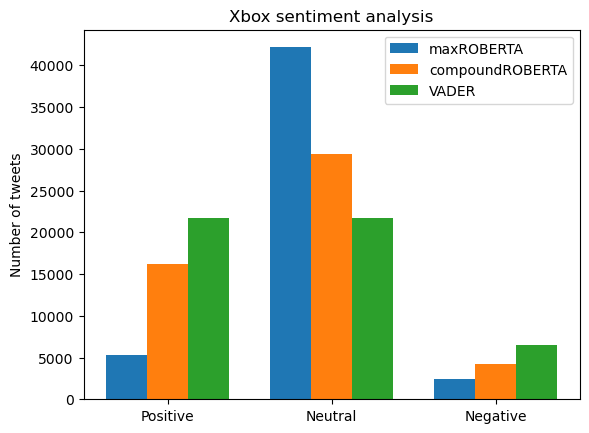

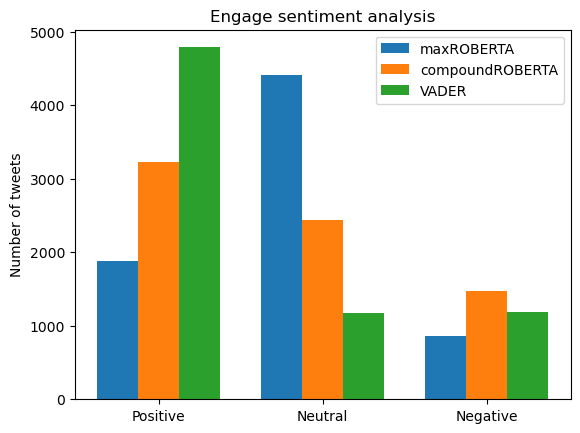

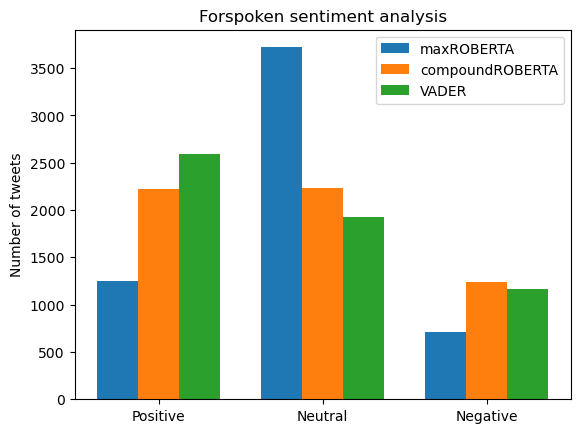

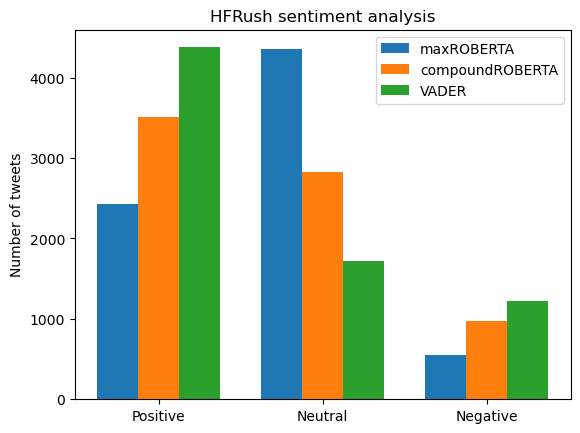

In [31]:
# Graph
index = np.arange(3)
bar_width = 0.25
for entity in entities:
    fig, ax = plt.subplots()
    i = 0
    for tipo in scoreTypes:
        y = [pos[entity][tipo], neu[entity][tipo], neg[entity][tipo]]
        subGrafico = ax.bar(index+bar_width*i, y, bar_width, label=f'{tipo}')
        i += 1
    #ax.set_xlabel('Sentiment')
    ax.set_ylabel('Number of tweets')
    ax.set_title(f'{entity} sentiment analysis')
    ax.set_xticks(index + bar_width)
    ax.set_xticklabels(["Positive", "Neutral", "Negative"])
    ax.legend()
    plt.show()

#### Raw comparison

We will take a look at the dataframes created, in order to check that the inferred sentiment from pre-trained models corresponds to what a person would detect. As we have seen that the maxROBERTA score is the most radical, we will randomly select one tweet of each type for all the entities, in order to get a diverse comparison of the tweets analyzed.

In [32]:
samples = []
rawNames = []
for entity in entities:
    for i in range(0,3):
        samples.append(tweets[entity][tweets[entity]['ROBERTAmaxSentiment'] == i].drop(['cleanText', 'finalText', 'stemmedText', 'lemmatizedText'], axis=1).sample())
        rawNames.append(entity)
raw = pd.concat(samples)
raw['tweet'] = rawNames

In [33]:
pd.set_option('display.max_colwidth', None) # Change options in order to see full text
raw

text  \
1006                                                                                                                                                                                           Really hoping the nintendo direct tomorrow isn't just full of shit lol   
10227  Shiny Houndoom! #pokémon #pokemon #pokemonscarlet #pokemonviolet #pokemonscarletandviolet #shinypokemon #shinypokemonhunting #nintendo #nintendoswitch #gamefreak #gamefreakpokemon #gamer #anime #trending #gamingcommunity #twitchtv https://t.co/CD2cFTEhmC   
9579                                                                                                                                                 Love how lame this score is, lol (I mostly play Nintendo games with a dash of PC games). https://t.co/nNp5kLSzlq   
39992                                                                                                                                              Now you can fuck and get your sister pregnant while playing on her Playstation!  win win 😏 https://t.co/yhOlmRQkhY   
33085                                                               Strimming fortnite Duo quick cups with @ice_XuwuX https://t.co/lCUBeePswE\n#RoadtoPartner #SupportSmallStreamers \n#Goodvibes\n#smallstreamer \n#Playstation\n#Fortnite\n#Zerobuild\n#FridayVibes   
24266                                                                                                                                            Birthday LAN party!  They are having a blast.  Thank you @Xbox @PlayStation @NintendoAmerica https://t.co/wapfP3fZvJ   
7094                                                                                                                                                                                                                             AOBA WHY DID YOU CANCEL MY XBOX LIVE   
45915                                                                                                                                                                                                                                   Guilty gear strive en xbox 🙏🏿   
13386                           Practically unanimous glowing reviews. Excellent sales. This game is already a huge hit. I don't support Rowling's transphobia at all, but this is the Harry Potter game we've all been waiting decades for.  https://t.co/wjp9hu3DkM   
438                                                                                                                                                                                               Found the jerks that been hurting the game. https://t.co/e2r9vSQ9U9   
6997                                                                                                                                                                    We are live now at https://t.co/AUl7oAL9z9 With Fire Emblem Engage! #Vtuber #VTuberEN #Femboy   
3766                                                                                                                            Had a fun time playing Gartic Phone, but now it's time to get back to my favorite group of idiots. FE: Engage continues in 15 Minutes   
1098                                                                                                                                                          SOMETHING JUST HAPPENED IN FORSPOKEN AND IM VERY UPSET \n\nI DIDNT SIGN UP TO CRY TONIGHT BUT HERE I AM   
3604                                                                                                                                                                                  The star of Forspoken isn’t bothered by all the memes\n https://t.co/HvPFiKDG15   
3329                                                                                                                           I really enjoyed what I played of #forspoken last night. I’m excited to play more of it soon and just parkouring and exploring is fun!   
6554             

In [34]:
pd.reset_option('^display.', silent=True) # Return to default options

## Critic reviews

We will make a disctintion between critic and user reviews due to the great difference between both of them. First of all, we will perform a sentiment analysis through the reviews written by the critics, comparing the **polarity** detected on each text with both the **grade** given by the critics and the **subjectivity** detected on each text.

### Data importation

In [35]:
# Define games and platforms
games = [
    {'title': 'fire-emblem-engage', 'platform': 'switch', 'name': 'feSwitch'},
    {'title': 'hi-fi-rush', 'platform': 'xbox-series-x', 'name': 'hfrushXbox'},
    {'title': 'hi-fi-rush', 'platform': 'pc', 'name': 'hfrushPc'},
    {'title': 'forspoken', 'platform': 'playstation-5', 'name': 'forspokenPS5'},
    {'title': 'forspoken', 'platform': 'pc', 'name': 'forspokenPc'}
]

In [36]:
# Import reviews
scoredReviews = {}
frames = []
for game in games:
    # Scored reviews
    scoredReviews[game["name"]] = pd.read_csv(f'Videojocs/cleanReviews/scored_{game["name"]}.csv')
    scoredReviews[game["name"]] = scoredReviews[game["name"]].drop(['source', 'link', 'date', 'cleanText', 'finalText', 'stemmedText'], axis=1)
    scoredReviews[game["name"]] = scoredReviews[game["name"]].dropna() # Drop NaN values
    scoredReviews[game["name"]]["videogame"] = game["name"]
    scoredReviews[game["name"]] = scoredReviews[game["name"]].sort_values(by=['grade'], ascending=False)
    # Unify both df in only one
    frames.append(scoredReviews[game["name"]])
criticReviews = pd.concat(frames)
criticReviews = criticReviews.sort_values(by=['grade'], ascending=False)

### Polarity

As we already know, **polarity** is a normalized scored that lies in the range \[-1,1\], indicating the negative or positive sentiment behind the text. We want to compare this to the scores given in the reviews, in order to see whether there is some kind of correlation between the texts and the grades. However, we need to previously scale the grades -that lie in the range \[0,100\]-, which can be easily done thanks to the following function:

$$f(x) = (\frac{2x}{100} - 1) \in [-1,1] \text{ for } x \in [0,100]$$

In [37]:
def critic_to_polarity(grade):
    return 2*grade/100 - 1

In [38]:
# Create a new column with normalized grades
for game in games:
    scoredReviews[game["name"]]['normalizedGrade'] = scoredReviews[game["name"]].grade.apply(lambda x: critic_to_polarity(x))

Now that we have the same range of scores, we will obtain the polarity thanks to two **pretrained models** and we will see which one of them is more accurate to the scores given.

#### VADER

In contrast to the previous section, where we only care about the general sentiment in the review, we will now take into account the compound score given by the model and compare it to the grades.

In [39]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sentiment = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\barri\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [40]:
for game in games: # Calculate sentiment for each game
    scoredReviews[game["name"]]['VADER'] = scoredReviews[game["name"]].lemmatizedText.apply(lambda x: sentiment.polarity_scores(x)['compound'])

We can now visualize the results and compare them to the normalized grades, as well as checking the distribution of the polarity detected compared to the score type of the review. In this last case, as some of the games do not have many reviews from critics, there are cases when a certain type of review does not even appear.

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

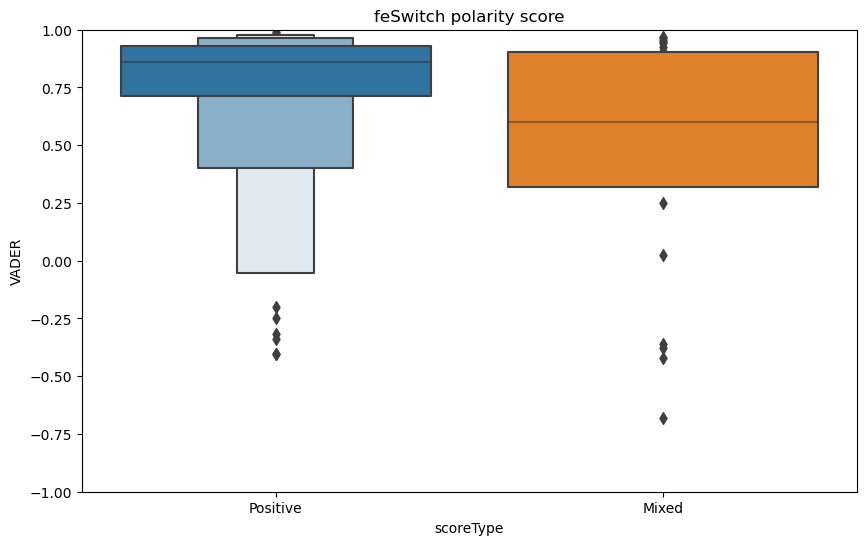

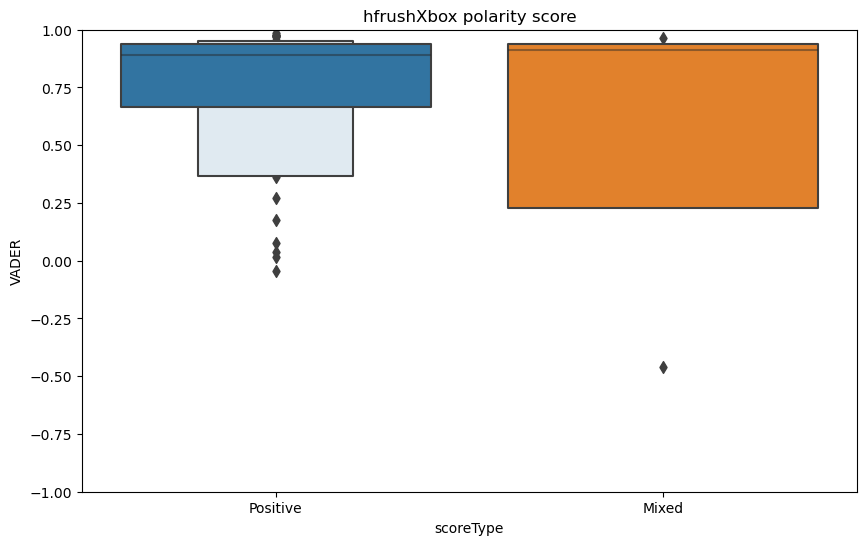

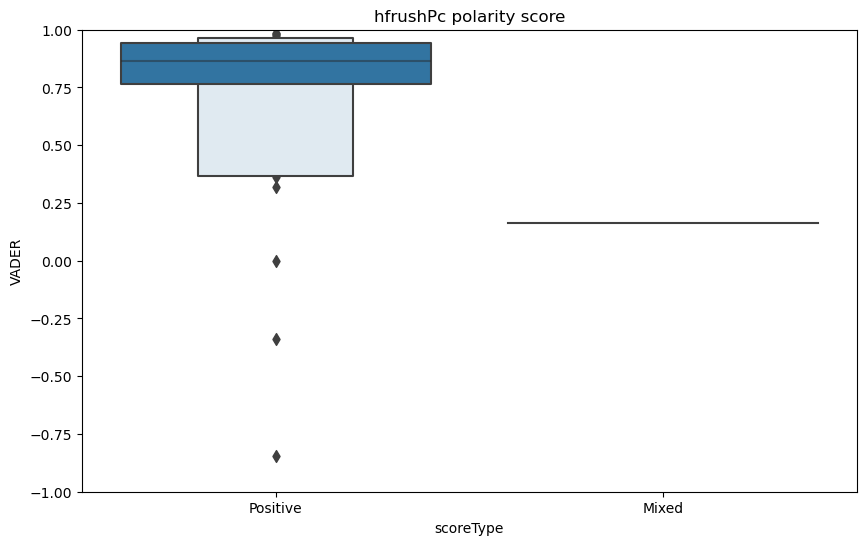

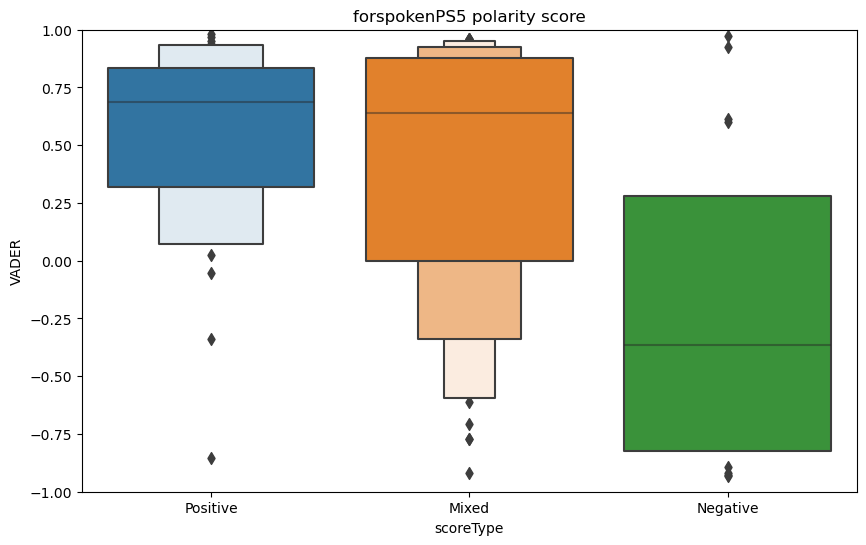

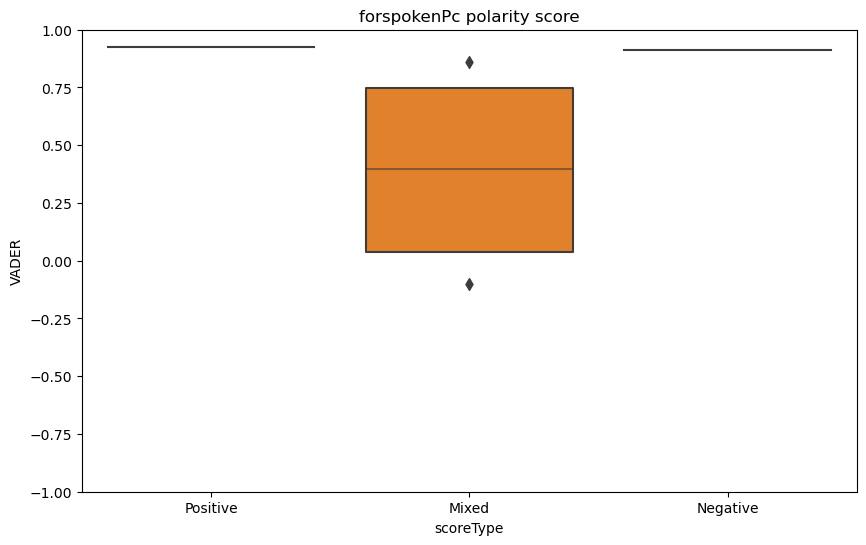

In [42]:
for game in games: # Comparison between sentiment detected and review type
    plt.figure(figsize=(10,6))
    plt.ylim([-1,1])
    plt.title(f'{game["name"]} polarity score')
    sns.boxenplot(x='scoreType', y='VADER', data=scoredReviews[game["name"]])
    plt.show();

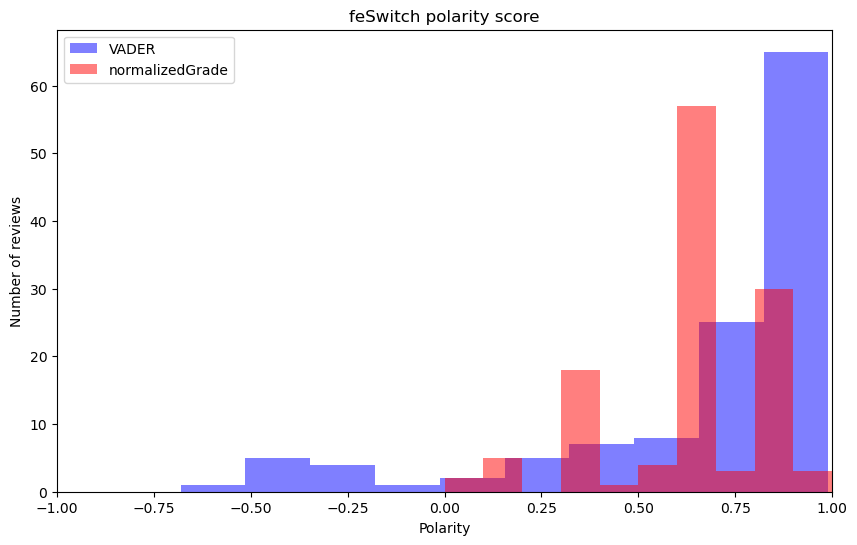

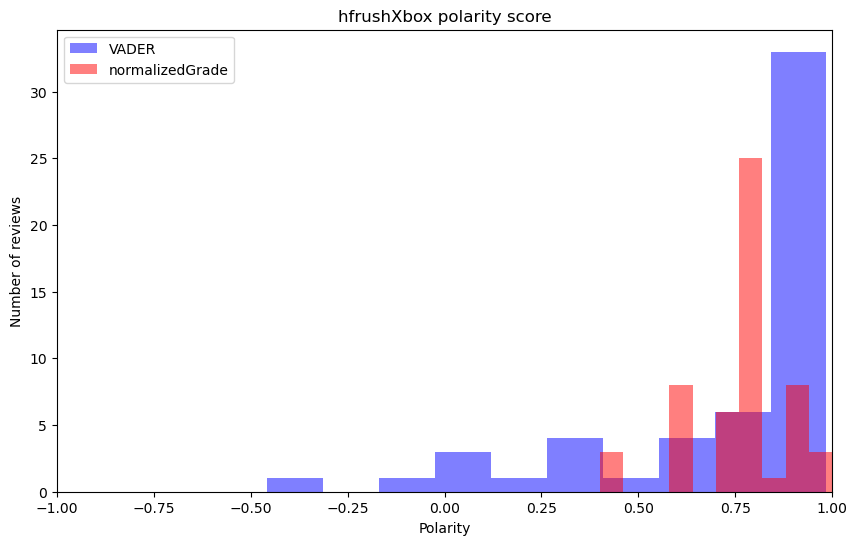

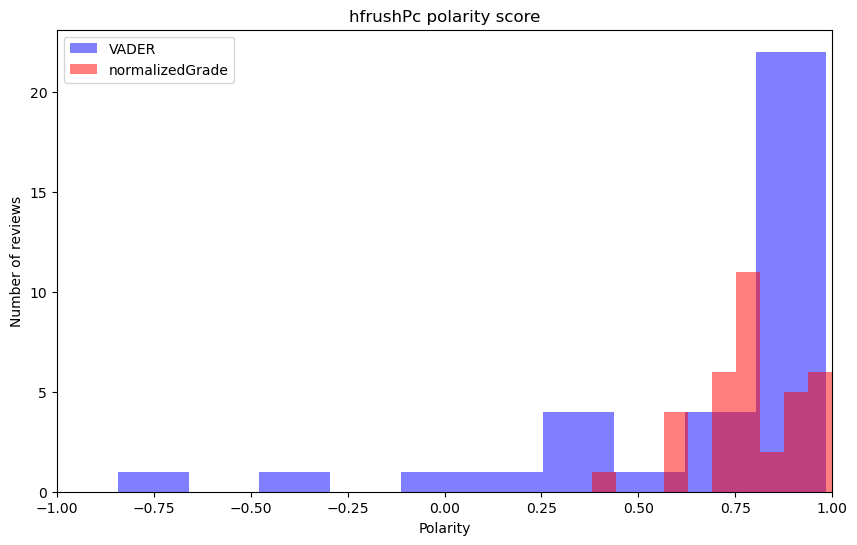

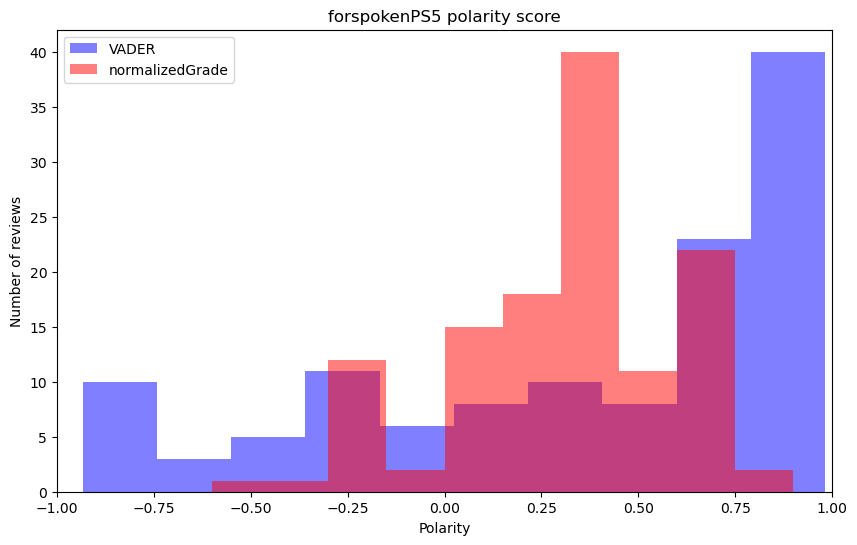

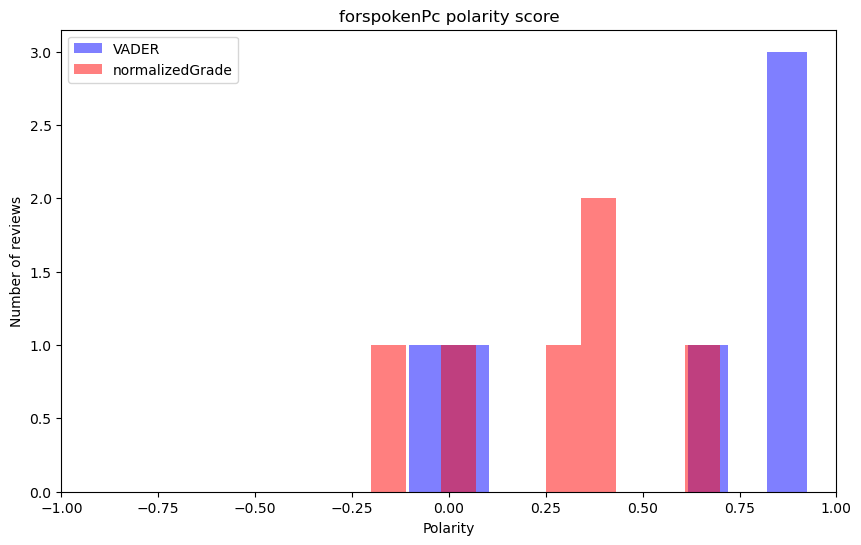

In [43]:
for game in games: # Comparison between perceived sentiment and "real sentiment"
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(scoredReviews[game["name"]].VADER, facecolor='blue', alpha=0.5, label='VADER')
    n, bins, patches = plt.hist(scoredReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

#### TextBlob

For this study, we will consider another model from *nltk* that also let us detect the subjectivity present in a text: **TextBlob**. When calculating sentiment, TextBlob takes average for entire text, so only the commmon meaning of a word in entire text is taken into account. These modelling is performed through the use of *WordNet Database*.

In [44]:
import nltk
nltk.download('wordnet')

# Import model
from textblob import TextBlob

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\barri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [45]:
for game in games: # Calculate sentiment for each game
    scoredReviews[game["name"]]['TextBlob'] = scoredReviews[game["name"]].lemmatizedText.apply(lambda x: TextBlob(x).sentiment.polarity)

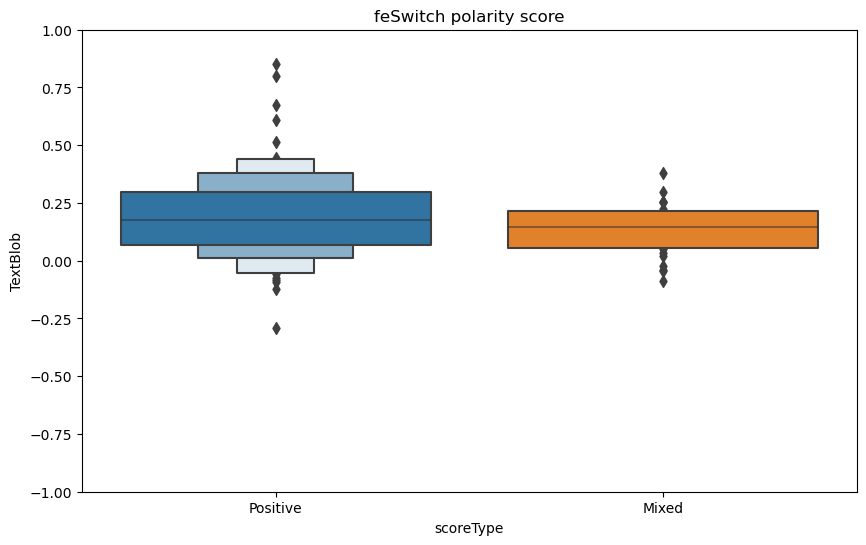

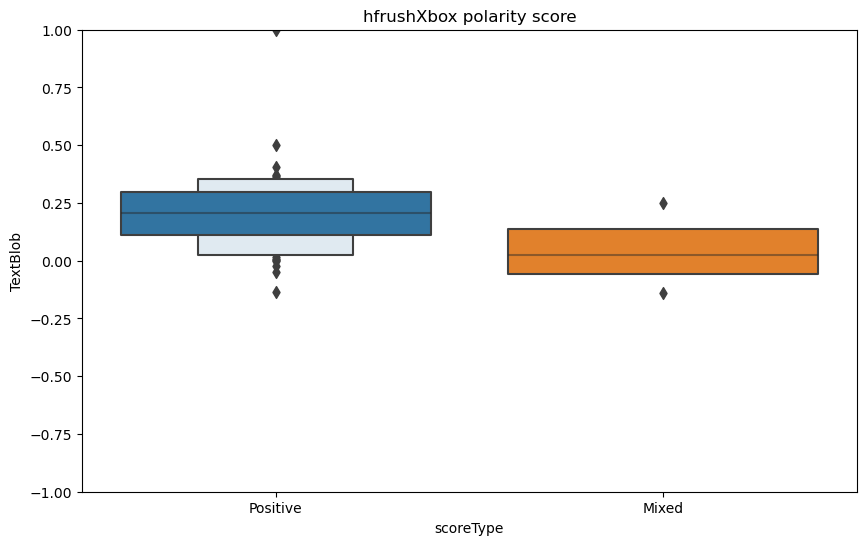

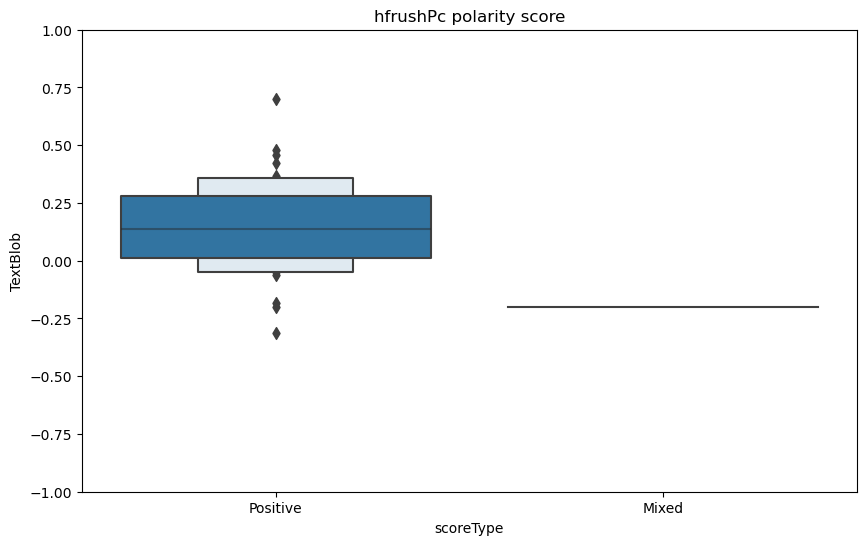

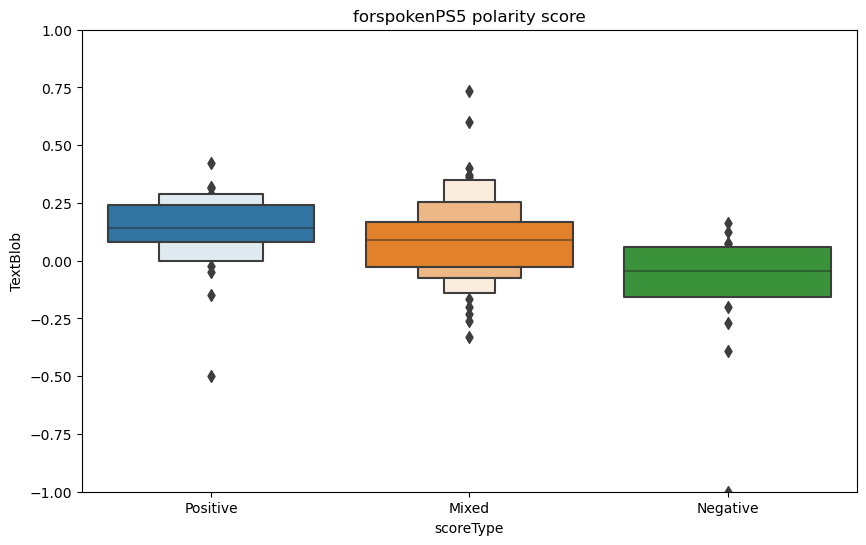

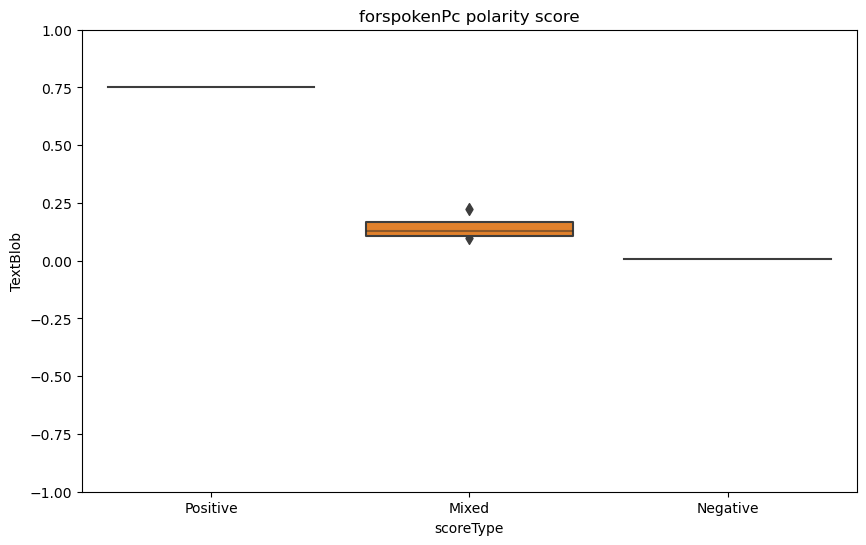

In [46]:
for game in games: # Comparison between sentiment detected and review type
    plt.figure(figsize=(10,6))
    plt.ylim([-1,1])
    plt.title(f'{game["name"]} polarity score')
    sns.boxenplot(x='scoreType', y='TextBlob', data=scoredReviews[game["name"]])
    plt.show();

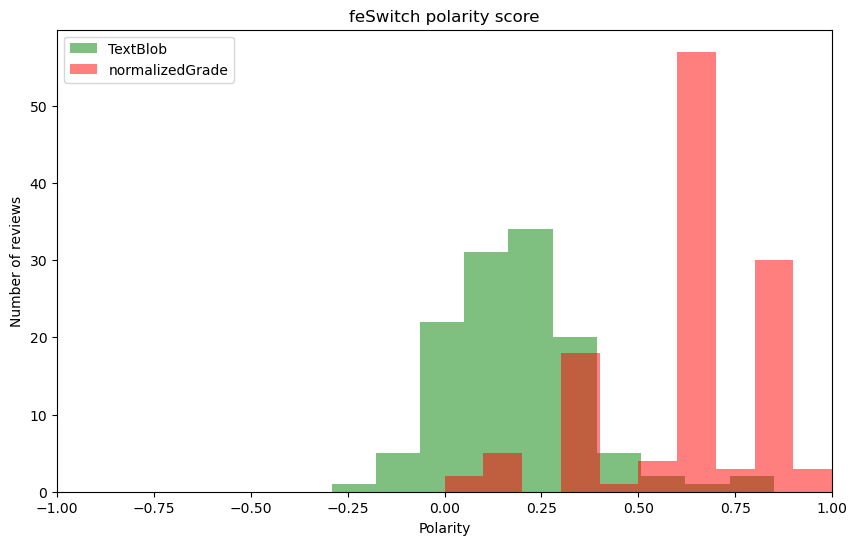

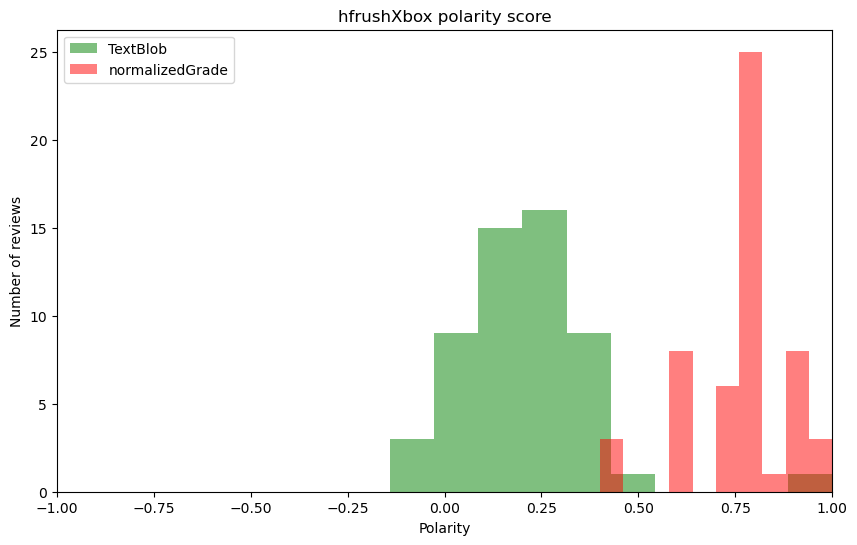

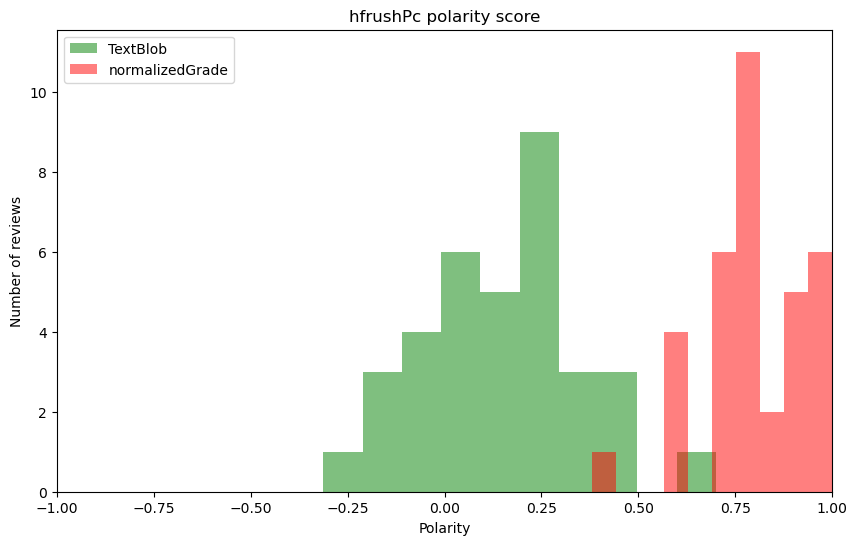

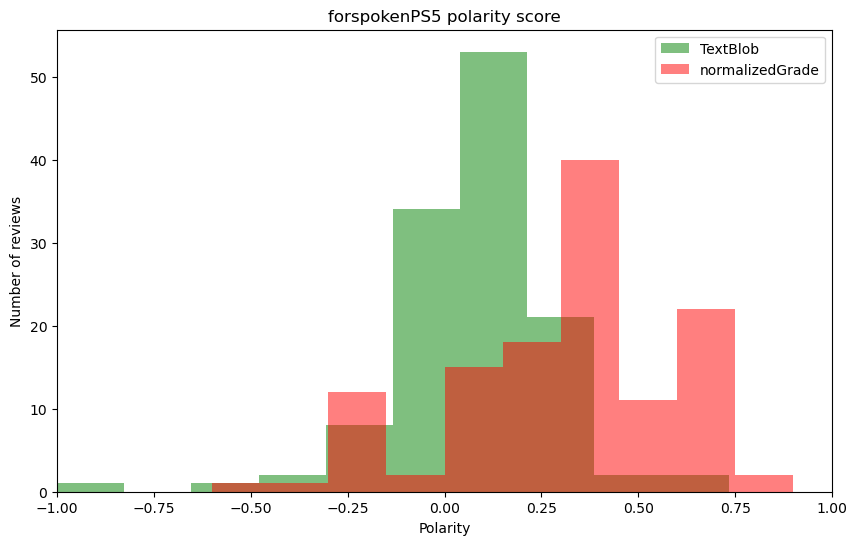

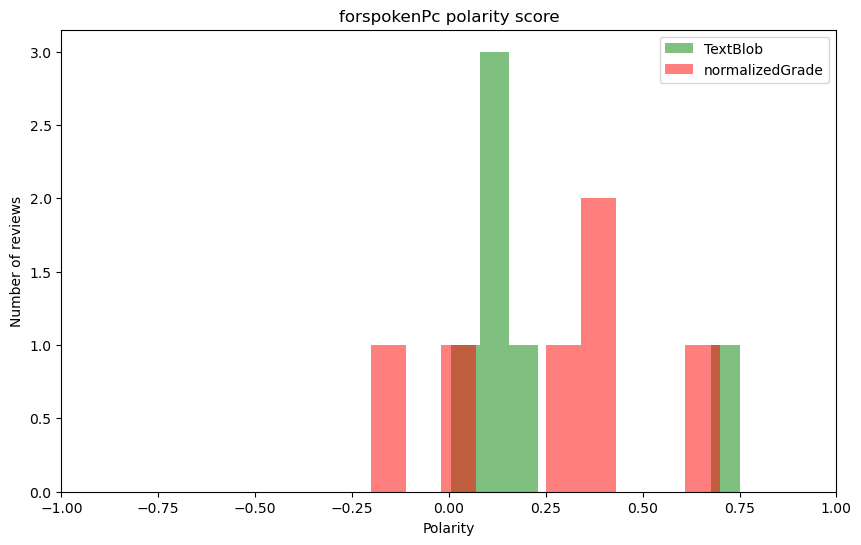

In [47]:
for game in games:
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(scoredReviews[game["name"]].TextBlob, facecolor='green', alpha=0.5, label='TextBlob')
    n, bins, patches = plt.hist(scoredReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

#### Graph comparison

Once we have the polarity for both models, we can compare all of them in the same diagram. As expected, VADER clearly outperforms TextBlob since this last one is a much simpler model that tends to classify the text in neutral values, not being able to detect highly polarized sentiment in texts.

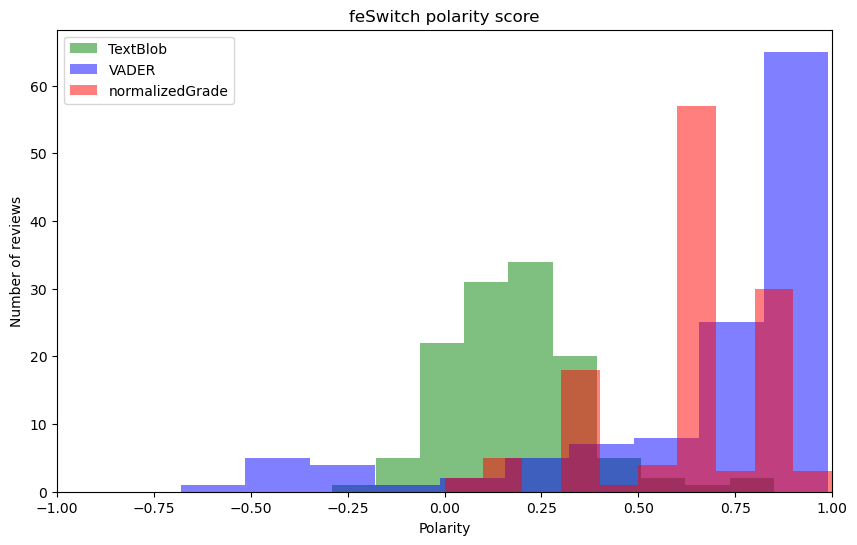

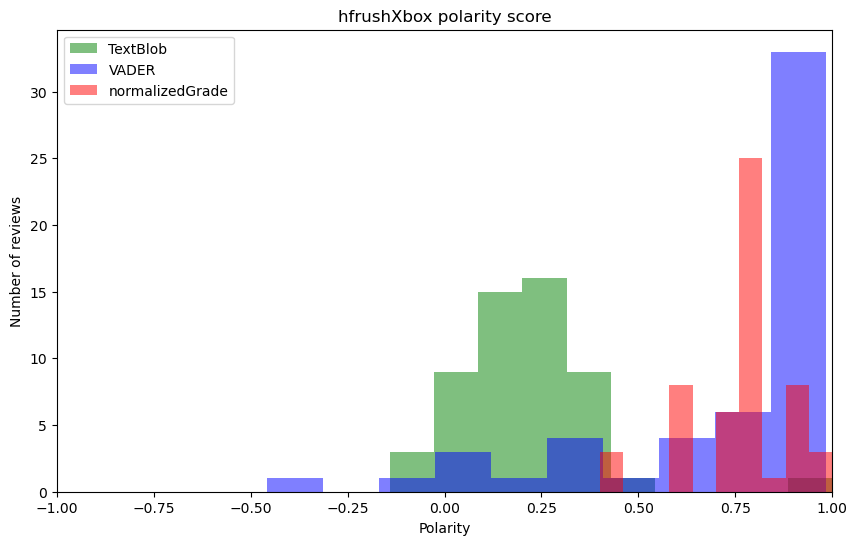

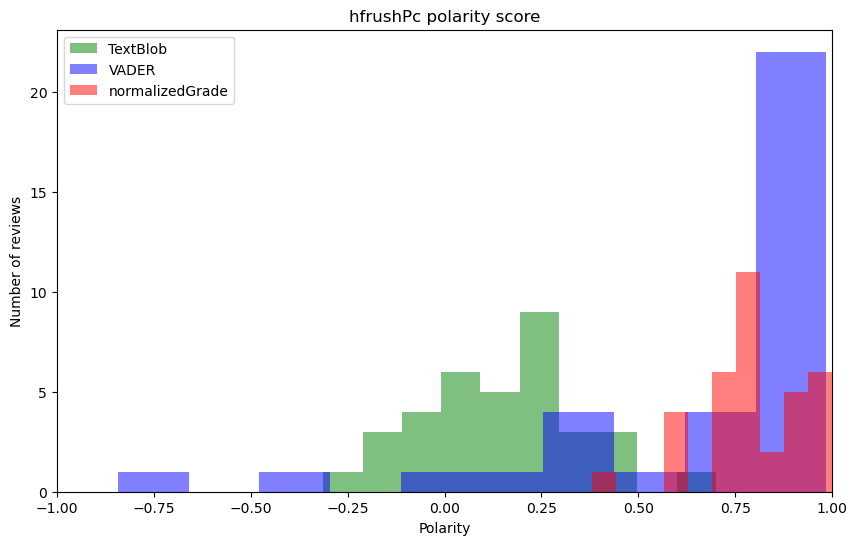

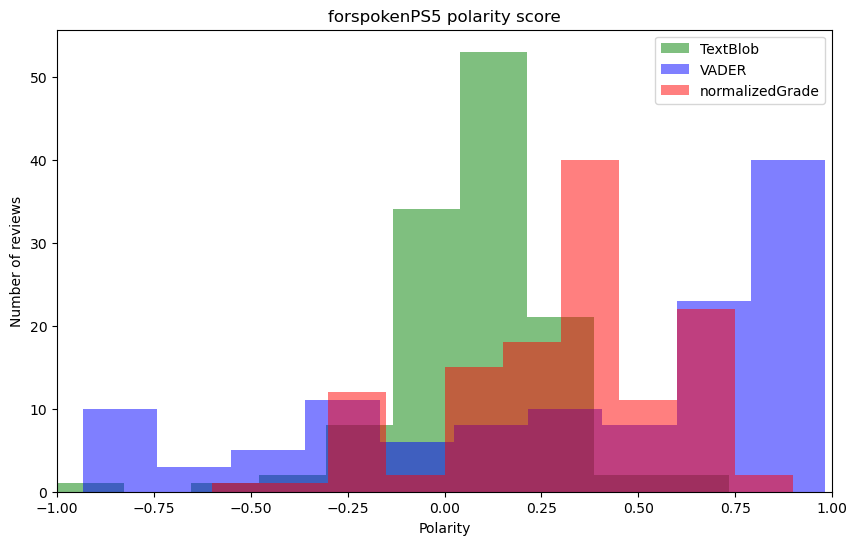

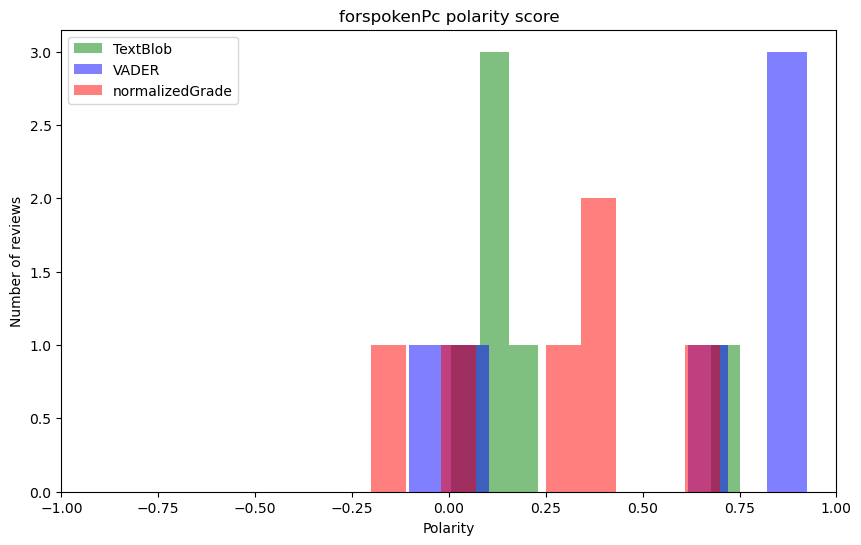

In [48]:
for game in games:
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(scoredReviews[game["name"]].TextBlob, facecolor='green', alpha=0.5, label='TextBlob')
    n, bins, patches = plt.hist(scoredReviews[game["name"]].VADER, facecolor='blue', alpha=0.5, label='VADER')
    n, bins, patches = plt.hist(scoredReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

### Subjectivity

**Subjectivity** is used to determine whether the analyzed text expresses an opinion or not. Obviously, all the texts that we are gonna analyze here are reviews from videogames, which imply a high degree of subjectivity. However, we would like to know if a certain degree of subjectivity also implies connotations with respect to the polarity in the text or the grade given.

Given the previous two models, only *TextBlob* let us extract the sentiment of the text, so that is the one that we are going to use. Mathematically, subjectivity is a float that lies in the range of \[0,1\]. The higher the value, the closer to an opinion is the text considered.

In [49]:
for game in games: # Calculate subjectivity for each game
    scoredReviews[game["name"]]['subjectivity'] = scoredReviews[game["name"]].lemmatizedText.apply(lambda x: TextBlob(x).sentiment.subjectivity)

C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

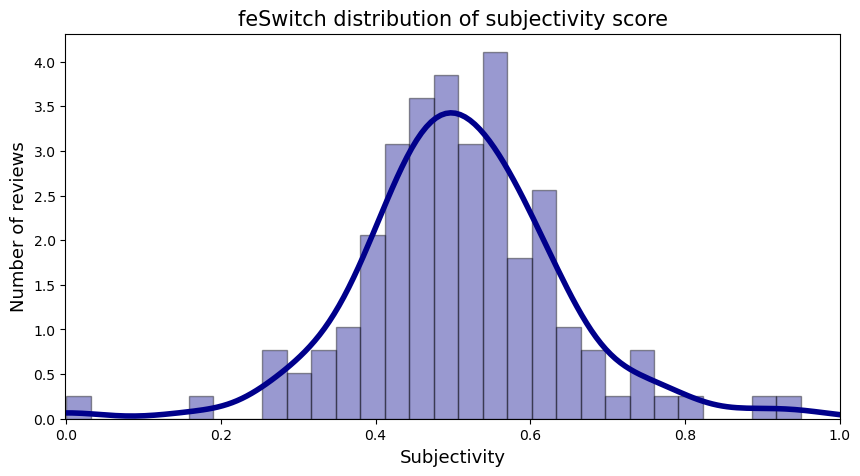

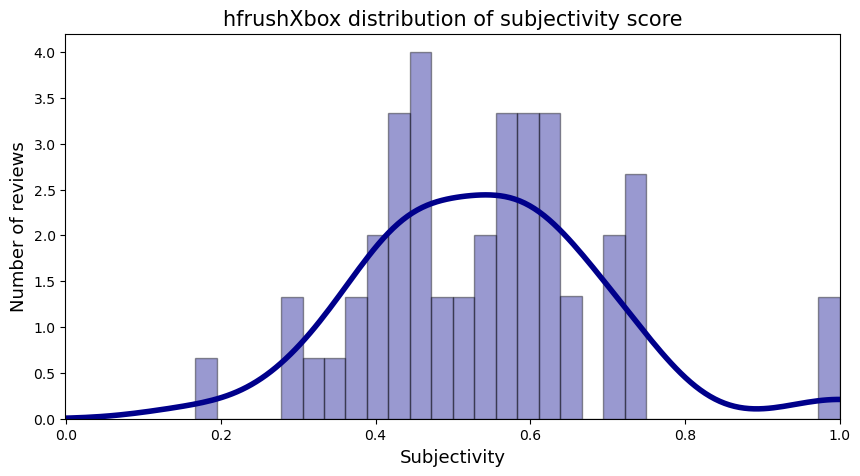

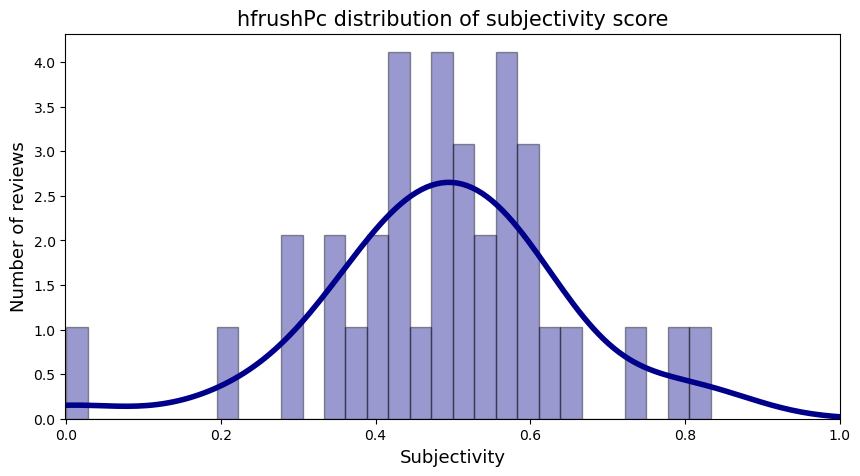

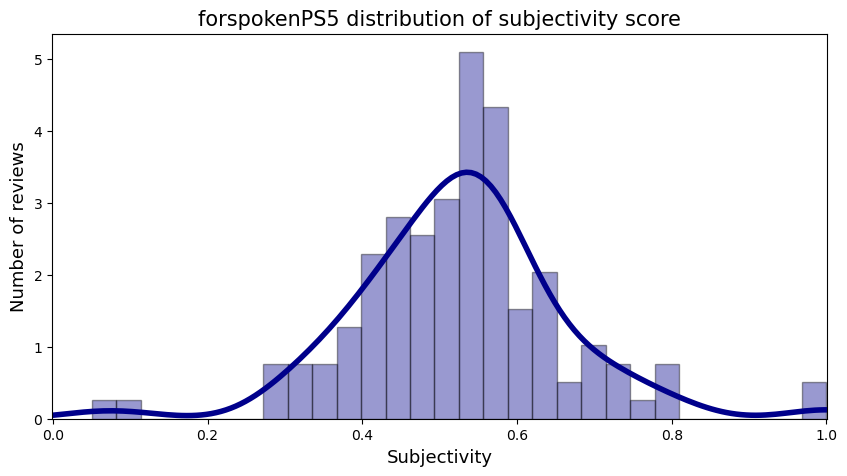

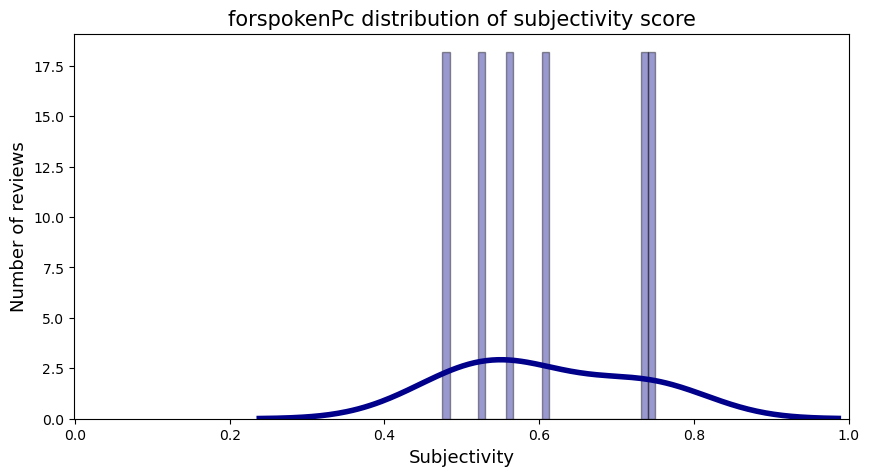

In [50]:
for game in games: # Density plot and histogram of subjectivity
    plt.figure(figsize=(10,5))
    sns.distplot(scoredReviews[game["name"]]['subjectivity'], hist=True, kde=True, bins=int(30), color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.xlim([-0.001,1.001])
    plt.xlabel('Subjectivity', fontsize=13)
    plt.ylabel('Number of reviews', fontsize=13)
    plt.title(f'{game["name"]} distribution of subjectivity score', fontsize=15)

Besides from this plot, we can also analize the influence of subjectivity in the polarity detected. In order to get a better understanding of the data, we can also group the reviews based on the ccategory of each review.

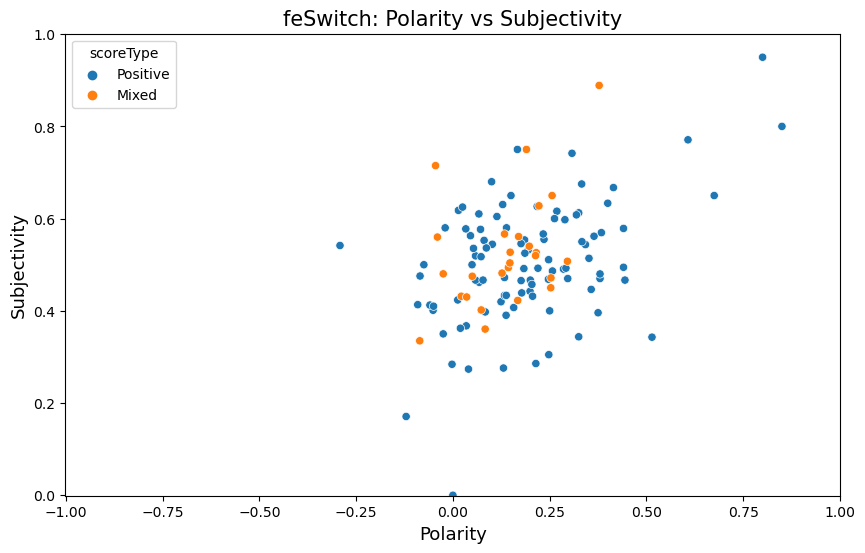

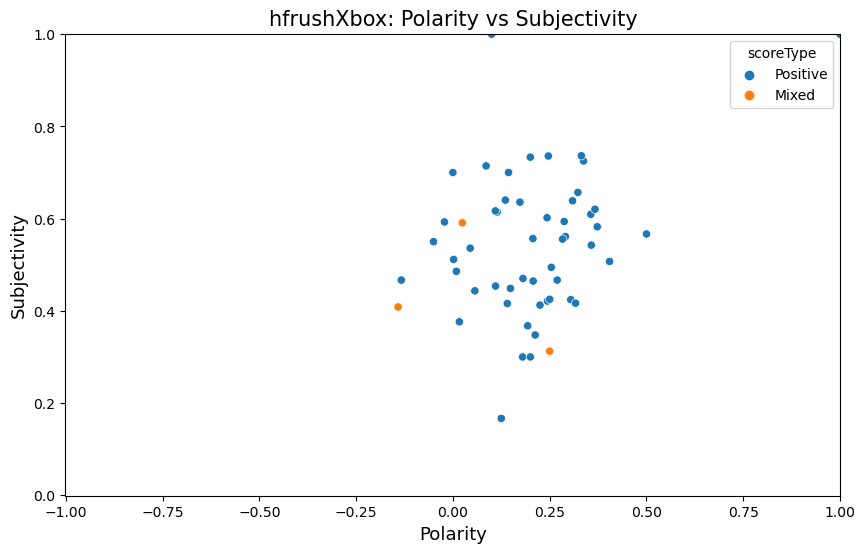

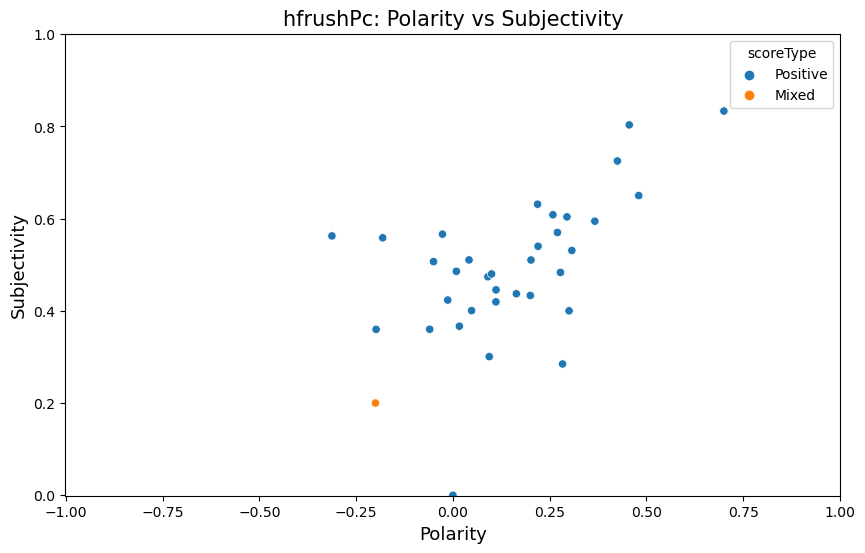

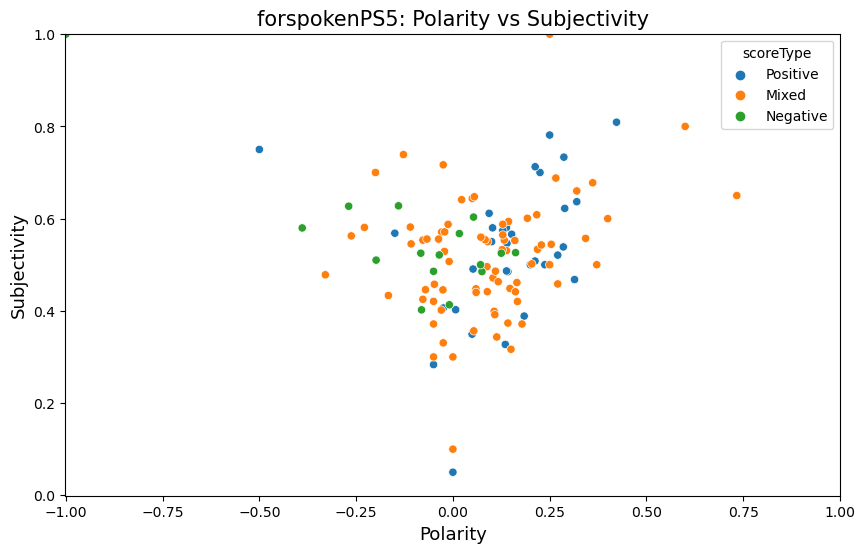

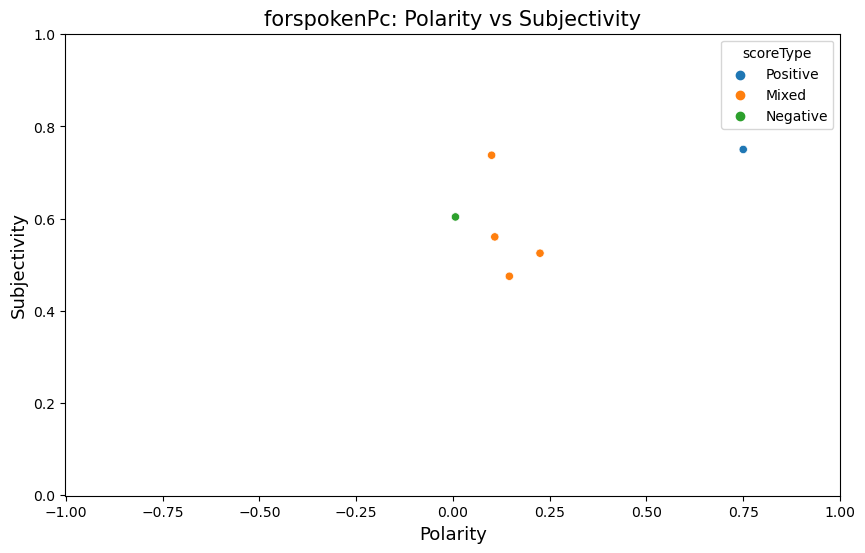

In [51]:
for game in games: # Polarity vs subjectivity
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='TextBlob', y='subjectivity', hue="scoreType", data=scoredReviews[game["name"]])
    plt.xlim([-1.001,1.001])
    plt.xlabel('Polarity', fontsize=13)
    plt.ylim([-0.001,1.001])
    plt.ylabel('Subjectivity', fontsize=13)
    plt.title(f'{game["name"]}: Polarity vs Subjectivity', fontsize=15)
    plt.show();

### Customized model

Sentiment is trained using sentiment classifiers. So far, we have only used pretrained classifiers that are trained on general texts. In this section, we will also train our own classifier in order to identify whether a review is positive, negative or mixed. We perform this over reviews since all the data is already labeled so the training of the models can be easily done.

#### Importations

We can now import the model and train it. We will use a **Multinomial Naive Bayes classifier**, that assumes that every feature contributes independently to the probability of each class, which is located between the NLP techniques as the so called **bag of words** approach.

Besides from the model, we also need to import the required modules for model evaluation, since performance evaluation is one of the key steps in the model training process.

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict, train_test_split

#### Train and test data

We need to split the data in two datasets: one for training the data (which is recommended to be between 80%-60% of all the data) and another one for testing the created model (20%-40% of the data). We also need to vectorize the data, as we keep it as a unique string.

In [53]:
# Select features and labels
X = criticReviews['lemmatizedText']
Y = criticReviews['scoreType']
# Create train and test datasets (70/30) stratified
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.3, random_state=13, stratify=Y)

In [54]:
# Creating the model. Parameters:
# min_df discards words appearing in less than min_df documents
# max_df discards words appearing in more than max_df% of the documents
# sublinear_tf usage of sublinear weighting (scale the term frequency in logarithmic scale)
# use_idf enables/disables the inverse document frequency
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

In [55]:
# Vectorize the texts
train_vectors = vectorizer.fit_transform(train_X)
test_vectors = vectorizer.transform(test_X)

#### Model training

We can finally check how well our model performed. We see that we have reached an accuracy of 77%. This is not a bad result, but it is a little low accuracy due to the few critic scored reviews that we have gotten. In the case of user's review we will get a better accuracy, since there are much more of them.

In [56]:
# Train the model
nb = MultinomialNB()
nb.fit(train_vectors, train_Y).score(test_vectors, test_Y)

0.7766990291262136

#### Model evaluation

Eventually, we will analyze the results obtained in terms of different scores. After that, we will perform the so called **cross-validation** in order to improve the accuracy of the model.

In [57]:
print("Multinomial Naive Bayes classifier")
print(classification_report(test_Y, nb.predict(test_vectors)))
predicted = cross_val_predict(nb, train_vectors, train_Y, cv=10)
print("Cross validation: %s" % accuracy_score(train_Y, predicted))

Multinomial Naive Bayes classifier
              precision    recall  f1-score   support

       Mixed       0.75      0.55      0.63        33
    Negative       0.00      0.00      0.00         5
    Positive       0.78      0.95      0.86        65

    accuracy                           0.78       103
   macro avg       0.51      0.50      0.50       103
weighted avg       0.74      0.78      0.75       103

Cross validation: 0.7196652719665272


C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will also show a **confusion matrix** that let us see more clearly the number of true/false positives/negatives that we have predicted.

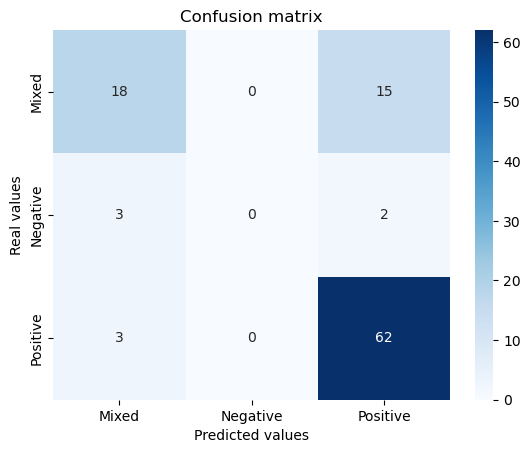

In [58]:
from pandas import DataFrame

confm = confusion_matrix(test_Y, nb.predict(test_vectors))
plt.figure()
df_cm = DataFrame(confm, index=['Mixed', 'Negative', 'Positive'], columns=['Mixed', 'Negative', 'Positive'])
ax = sns.heatmap(df_cm, cmap='Blues', annot=True)
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.title('Confusion matrix')
print('')

#### Model saving

To conclude, we will just save the model in case that we want to use it in the future.

In [59]:
import pickle as pkl

filepath = f'Modelos/sentiment/criticReviews.pkl'
with open(filepath, "wb") as file:
    pkl.dump(nb, file)

## User reviews

After the previous analysis, this one is very similar. Howevere, we expect the results to be more accurate since we have a higher amount of data. Besides, we can perform and extra analysis since there is a metric present in the user reviews that is not in the critics: **helpfulness**.

### Data importation

In [60]:
# Import reviews
userReviews = {}
frames = []
for game in games:
    # Scored reviews
    userReviews[game["name"]] = pd.read_csv(f'Videojocs/cleanReviews/user_{game["name"]}.csv')
    userReviews[game["name"]] = userReviews[game["name"]].drop(['source', 'link', 'date', 'cleanText', 'finalText', 'stemmedText'], axis=1)
    userReviews[game["name"]] = userReviews[game["name"]].dropna() # Drop NaN values
    userReviews[game["name"]]["videogame"] = game["name"]
    userReviews[game["name"]] = userReviews[game["name"]].sort_values(by=['grade'], ascending=False)
    # Unify both df in only one
    frames.append(userReviews[game["name"]])
allUserReviews = pd.concat(frames)
allUserReviews = allUserReviews.sort_values(by=['grade'], ascending=False)

In [61]:
allUserReviews

grade scoreType                                               text  \
178     10  Positive  Absolutely loving it so far. Just don't expect...   
52      10  Positive  I had not any interest in these type of games....   
79      10  Positive  This game is amazing because it is an integrat...   
80      10  Positive  I LOVE THIS GAME!!! It's unreal the nostalgic ...   
81      10  Positive  Incredible! If Jet Set Radio and DMC had a bab...   
..     ...       ...                                                ...   
56       0  Negative  This is a gold plated turd.  It's clear that t...   
44       0  Negative  Worst dialog and voice acting I've ever  exper...   
43       0  Negative  Huge let down, for a Playstation exclusive thi...   
478      0  Negative  A solid 8/10 not the best game but it's much b...   
62       0  Negative  If the PS5 version is bad, it was not necessar...   

     upThumbs  totalThumbs  helpfulness  \
178        14           27     0.518519   
52          1            1     1.000000   
79          9           11     0.818182   
80          8           10     0.800000   
81          8           10     0.800000   
..        ...          ...          ...   
56          2            2     1.000000   
44         27           50     0.540000   
43         30           55     0.545455   
478         1            8     0.125000   
62         11           16     0.687500   

                                        lemmatizedText     videogame  
178  absolutely loving far expect three house class...      feSwitch  
52   interest type game playing gamepass bought gam...    hfrushXbox  
79        game amazing integrated art love making game    hfrushXbox  
80   love game unreal nostalgic game rise little ta...    hfrushXbox  
81   incredible jet set radio dmc baby would result...    hfrushXbox  
..                                                 ...           ...  
56   gold plated turd clear big budget developed id...  forspokenPS5  
44   worst dialog voice acting ever experienced gam...  forspokenPS5  
43   huge let playstation exclusive absolutely tras...  forspokenPS5  
478  solid 10 best game much better game like elden...  forspokenPS5  
62   ps5 version bad necessary release pc surely ga...   forspokenPc  

[1434 rows x 8 columns]

### Polarity

As we already know, **polarity** is a normalized scored that lies in the range \[-1,1\], indicating the negative or positive sentiment behind the text. We want to compare this to the scores given in the reviews, in order to see whether there is some kind of correlation between the texts and the grades. However, we need to previously scale the grades -that lie in the range \[0,10\]-, which can be easily done thanks to the following function:

$$f(x) = (\frac{2x}{10} - 1) \in [-1,1] \text{ for } x \in [0,10]$$

In [62]:
def user_to_polarity(grade):
    return 2*grade/10 - 1

In [63]:
# Create a new column with normalized grades
for game in games:
    userReviews[game["name"]]['normalizedGrade'] = userReviews[game["name"]].grade.apply(lambda x: user_to_polarity(x))

Now that we have the same range of scores, we will obtain the polarity thanks to two **pretrained models** and we will see which one of them is more accurate to the scores given.

#### VADER

In contrast to the previous section, where we only care about the general sentiment in the review, we will now take into account the compound score given by the model and compare it to the grades.

In [64]:
sentiment = SentimentIntensityAnalyzer()

In [65]:
for game in games: # Calculate sentiment for each game
    userReviews[game["name"]]['VADER'] = userReviews[game["name"]].lemmatizedText.apply(lambda x: sentiment.polarity_scores(x)['compound'])

We can now visualize the results and compare them to the normalized grades, as well as checking the distribution of the polarity detected compared to the score type of the review. In this last case, as some of the games do not have many reviews from critics, there are cases when a certain type of review does not even appear.

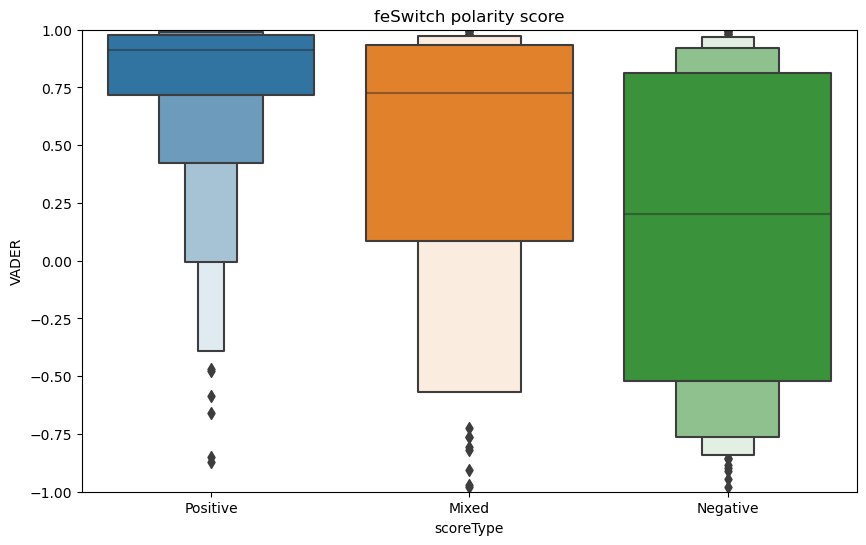

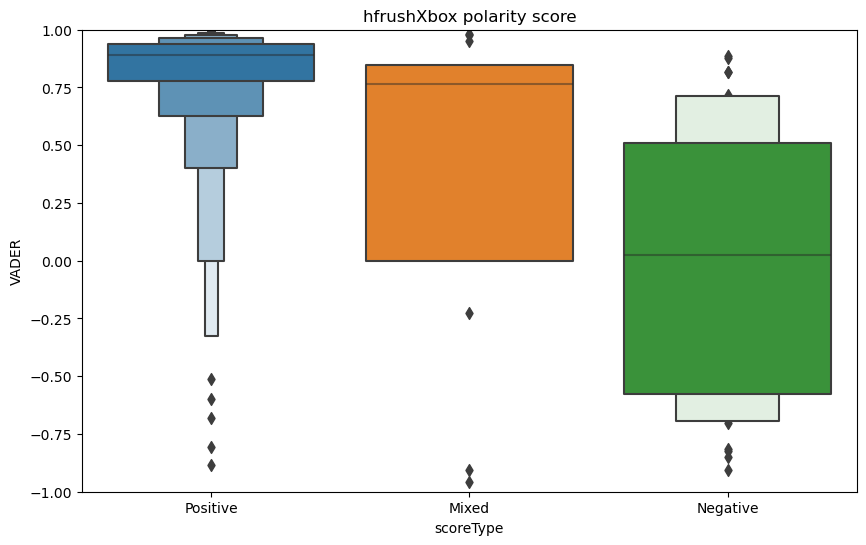

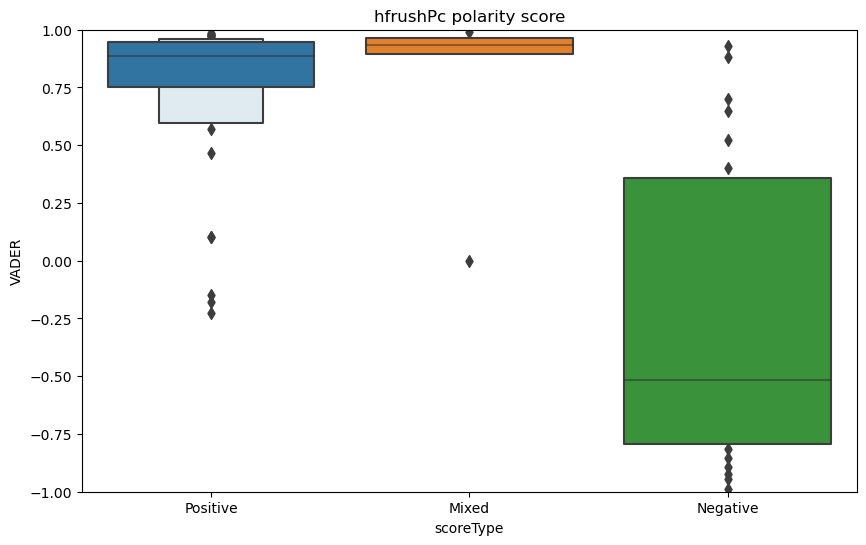

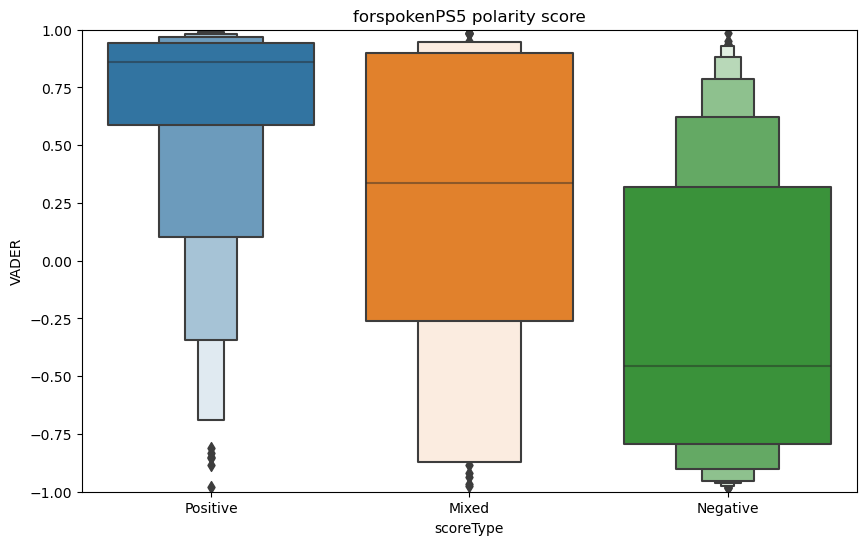

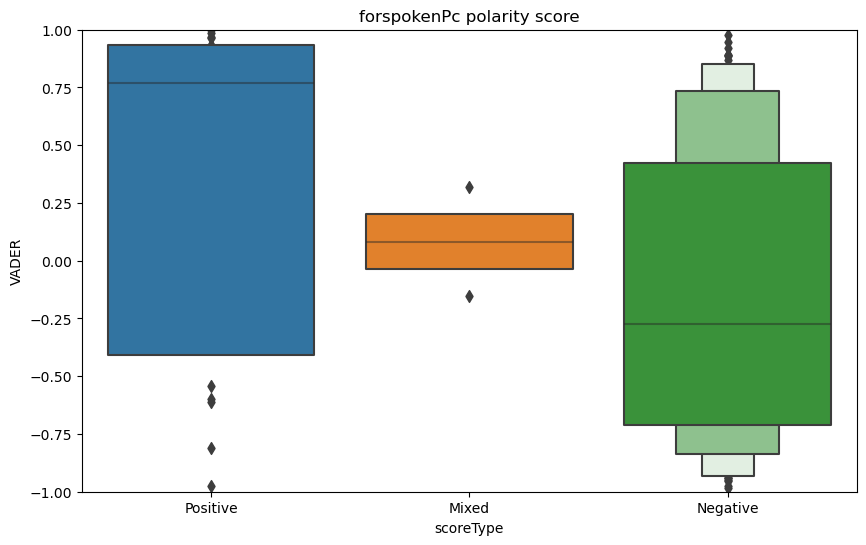

In [66]:
for game in games: # Comparison between sentiment detected and review type
    plt.figure(figsize=(10,6))
    plt.ylim([-1,1])
    plt.title(f'{game["name"]} polarity score')
    sns.boxenplot(x='scoreType', y='VADER', data=userReviews[game["name"]])
    plt.show();

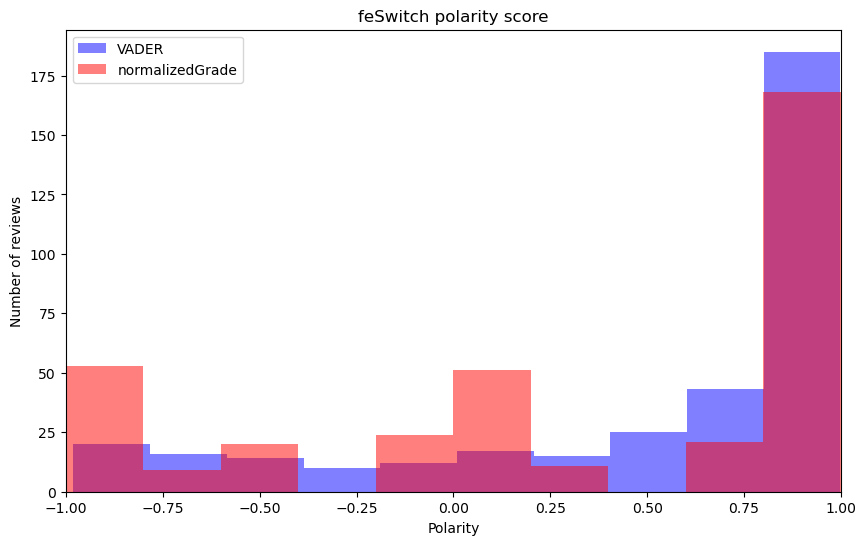

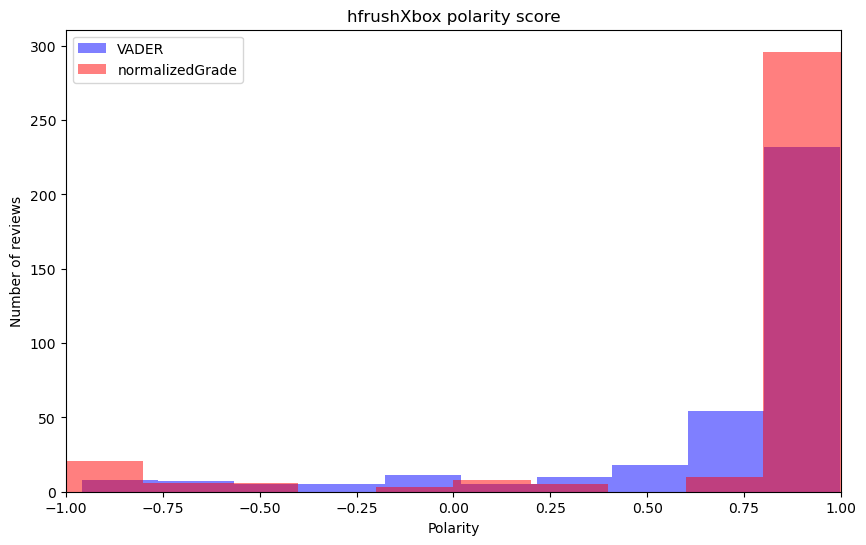

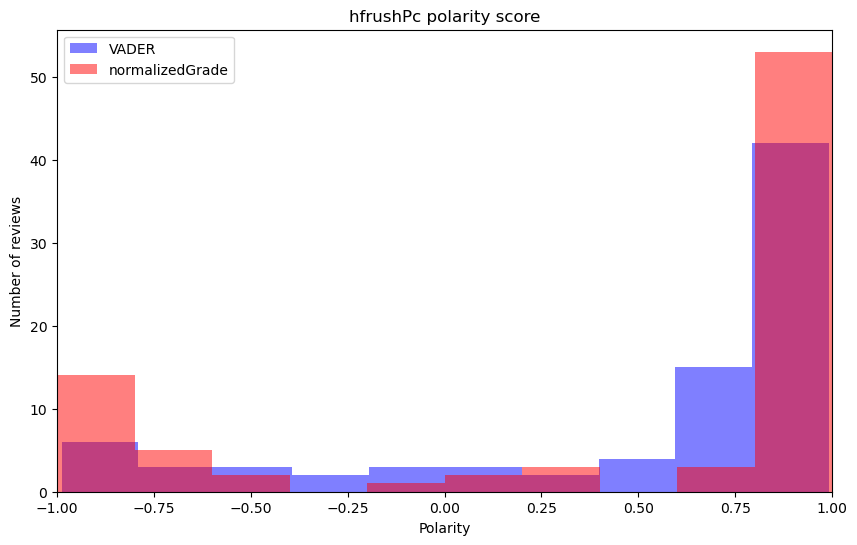

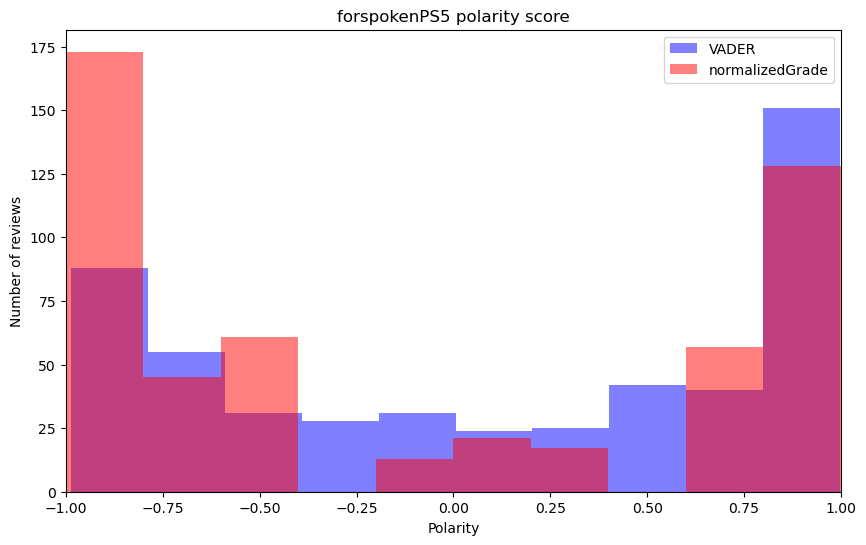

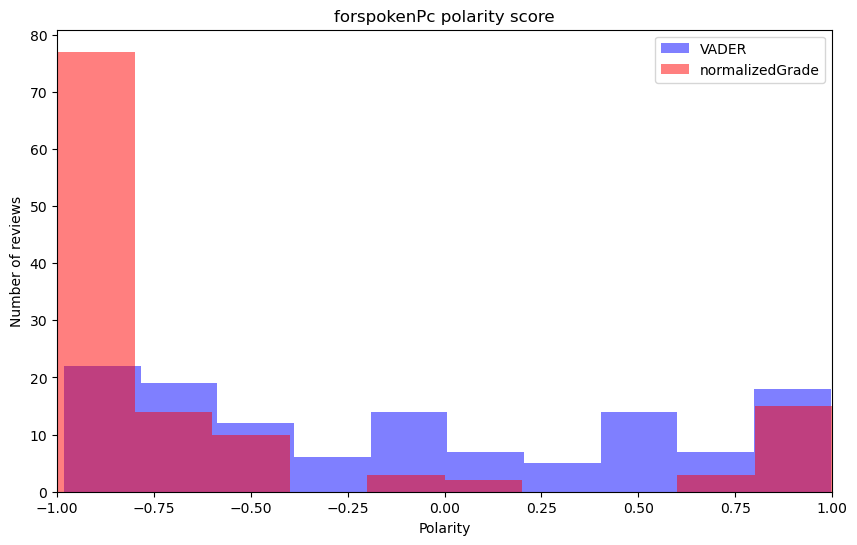

In [67]:
for game in games: # Comparison between perceived sentiment and "real sentiment"
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(userReviews[game["name"]].VADER, facecolor='blue', alpha=0.5, label='VADER')
    n, bins, patches = plt.hist(userReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

##### Helpfulness

In the case of the user reviews, we have an additional metric to evaluate them: **helpfulness**. It let other user to say whether the given review has some kind of relevance/utility. We will compare this indicator to the polarity of the reviews, both the ratio of positive interactions with respect to the total amount of interactions as well as just the number of interactions given by the community. 

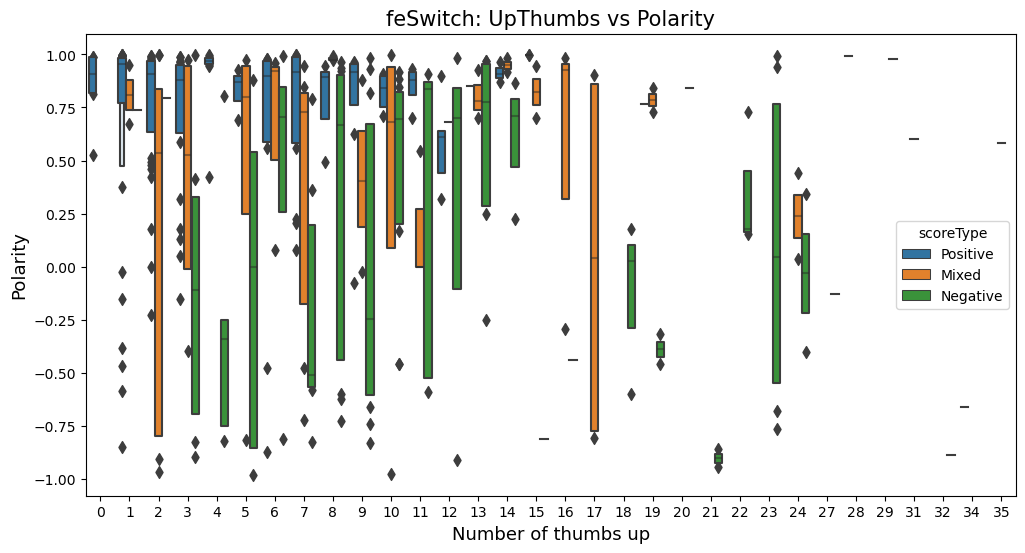

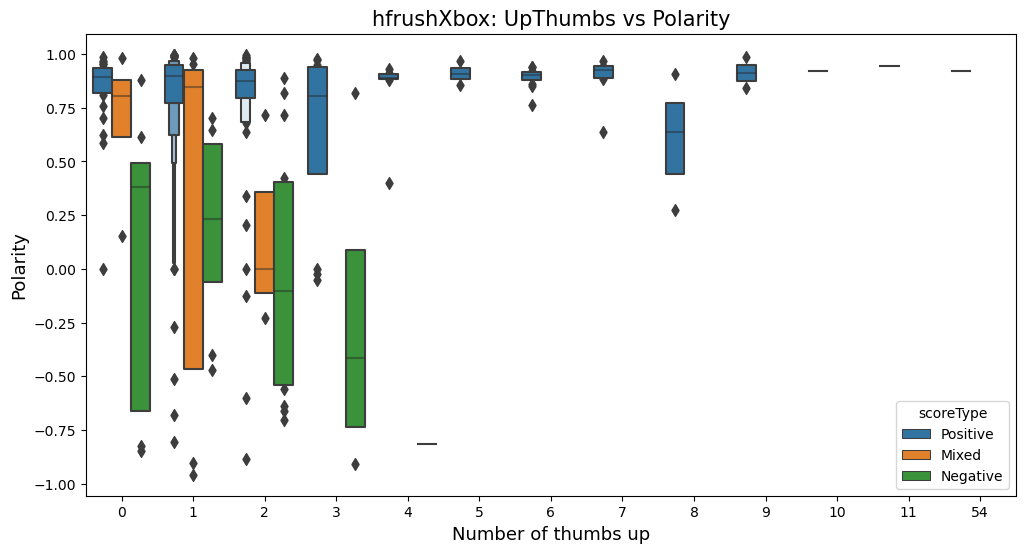

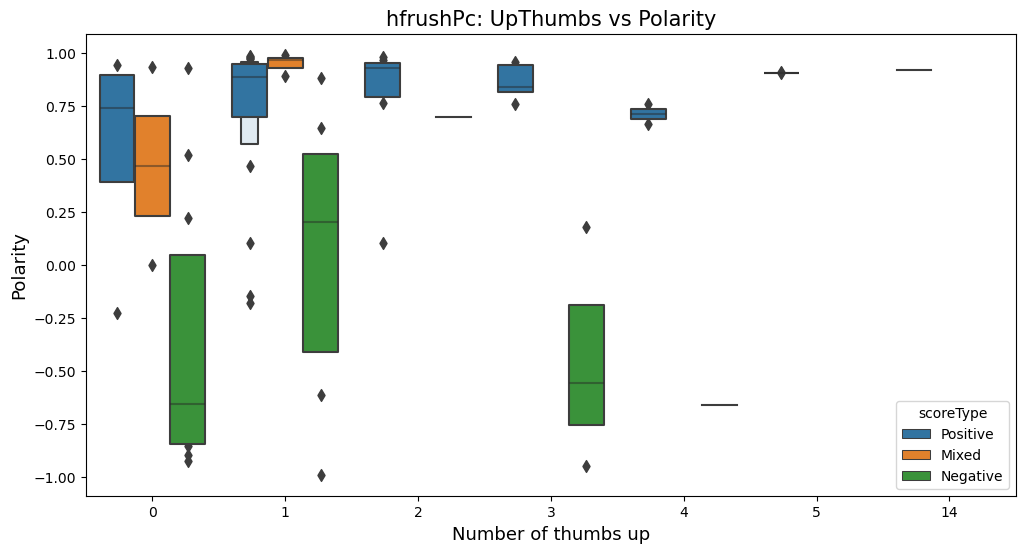

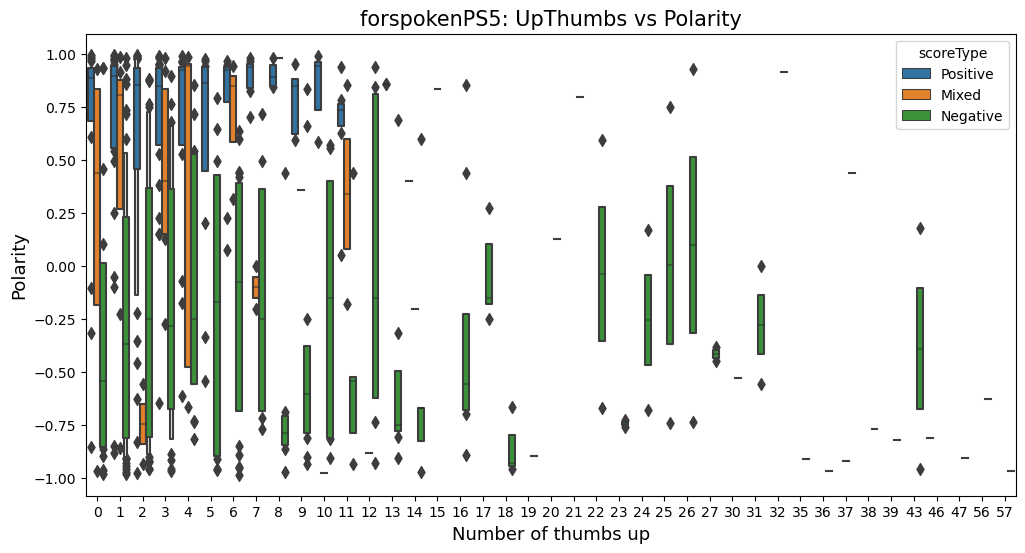

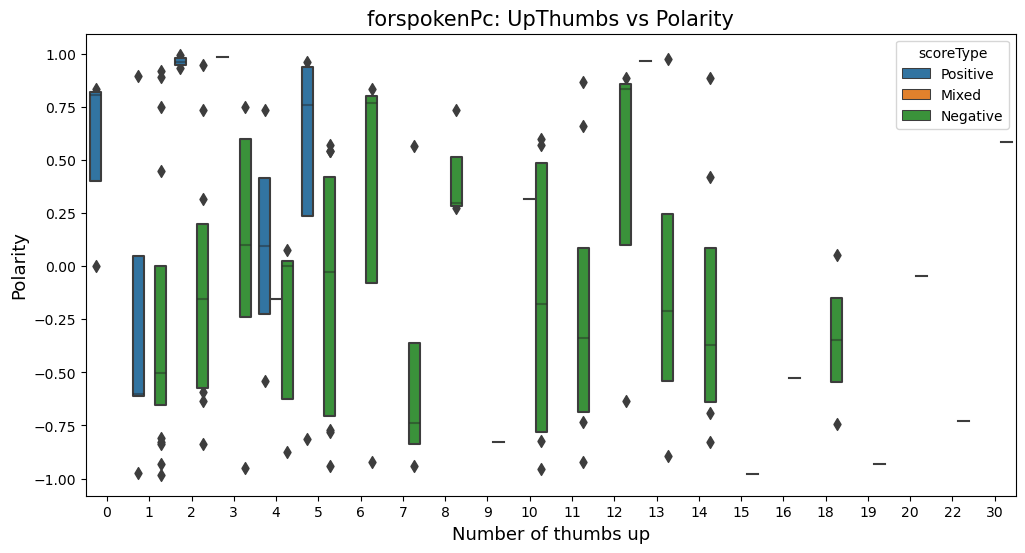

In [68]:
for game in games: # Consider only upThumbs instead of ratio
    plt.figure(figsize=(12,6))
    sns.boxenplot(x='upThumbs', y='VADER', hue='scoreType', data=userReviews[game["name"]])
    plt.xlabel('Number of thumbs up', fontsize=13)
    plt.ylabel('Polarity', fontsize=13)
    plt.title(f'{game["name"]}: UpThumbs vs Polarity', fontsize=15)
    plt.show();

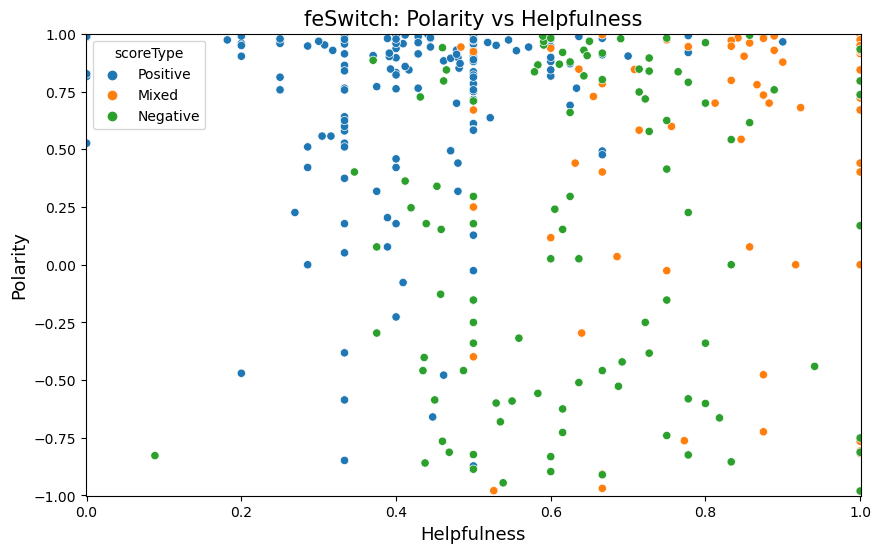

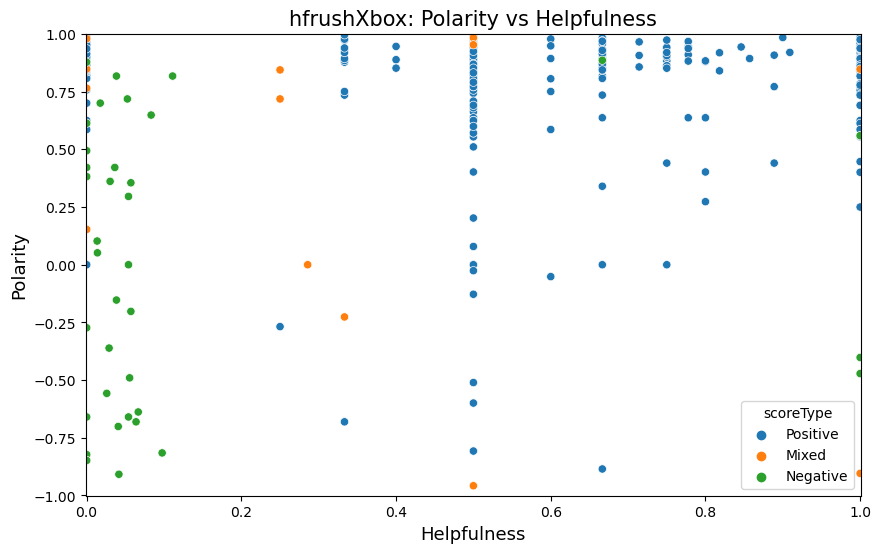

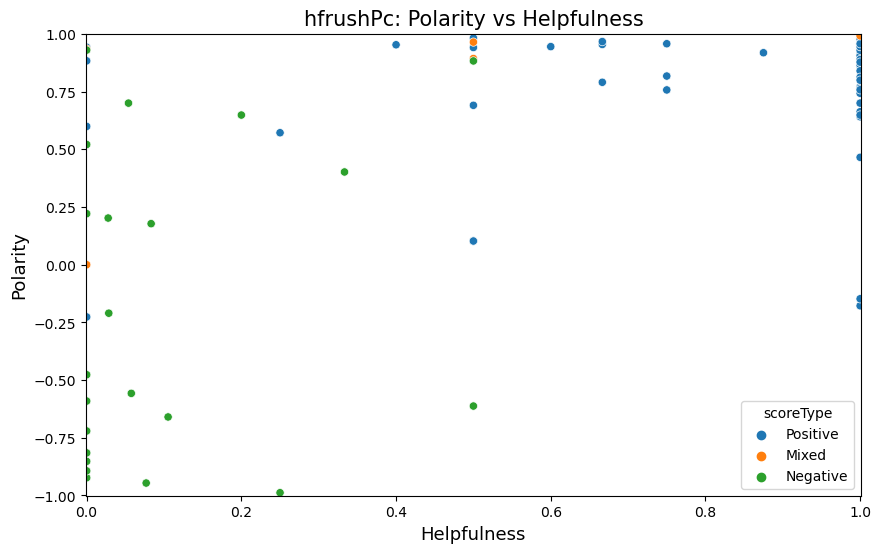

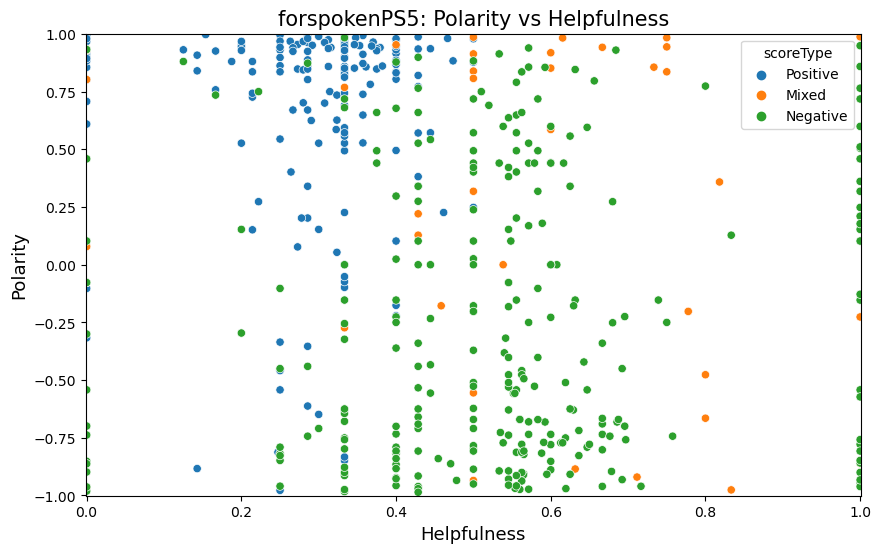

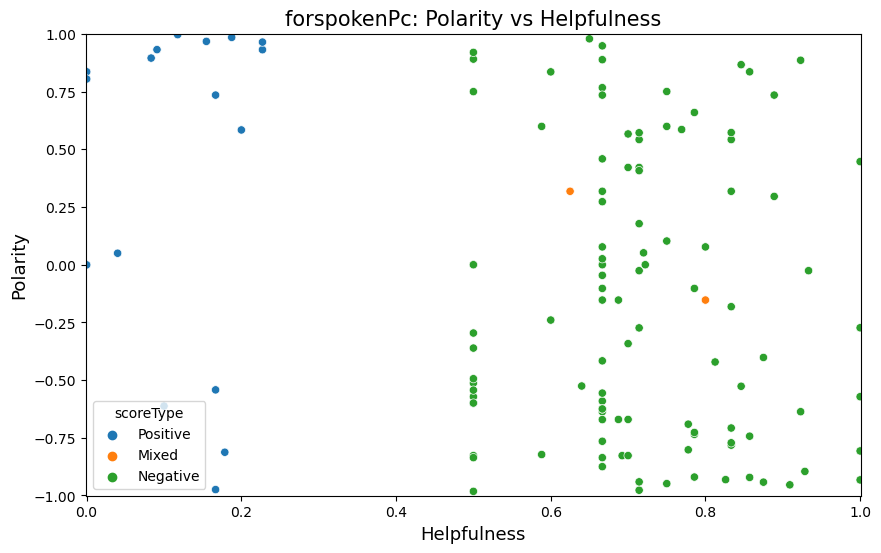

In [69]:
for game in games: # Polarity vs Helpfulness
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='helpfulness', y='VADER', hue="scoreType", data=userReviews[game["name"]])
    plt.xlim([-0.001,1.001])
    plt.xlabel('Helpfulness', fontsize=13)
    plt.ylim([-1.001,1.001])
    plt.ylabel('Polarity', fontsize=13)
    plt.title(f'{game["name"]}: Polarity vs Helpfulness', fontsize=15)
    plt.show();

#### TextBlob

For this study, we will consider another model from *nltk* that also let us detect the subjectivity present in a text: **TextBlob**. When calculating sentiment, TextBlob takes average for entire text, so only the commmon meaning of a word in entire text is taken into account. These modelling is performed through the use of *WordNet Database*.

In [70]:
for game in games: # Calculate sentiment for each game
    userReviews[game["name"]]['TextBlob'] = userReviews[game["name"]].lemmatizedText.apply(lambda x: TextBlob(x).sentiment.polarity)

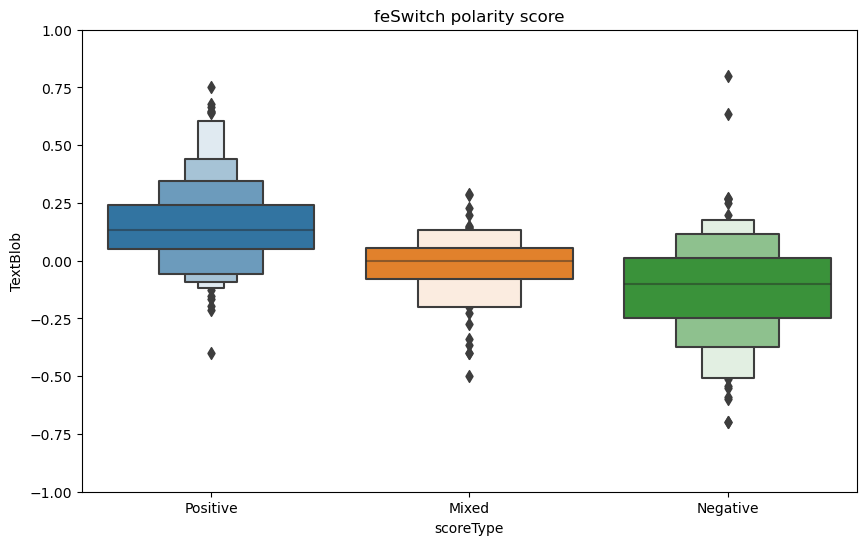

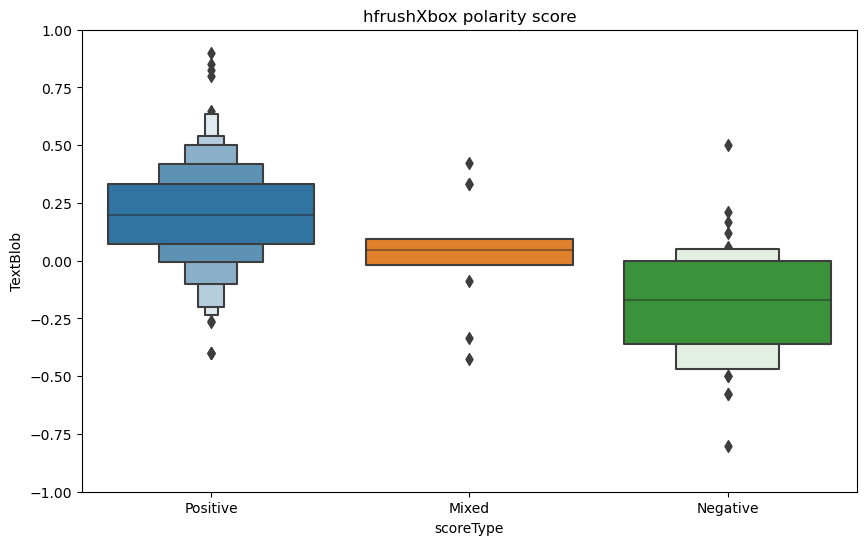

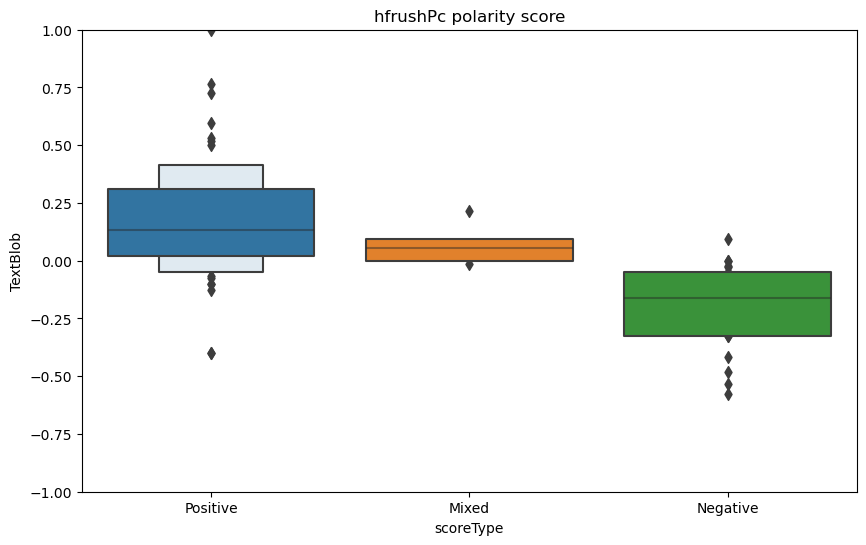

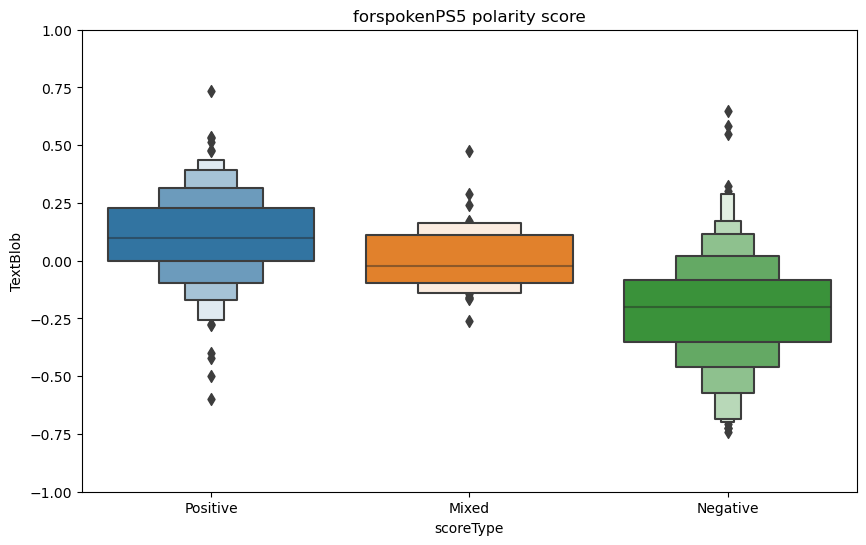

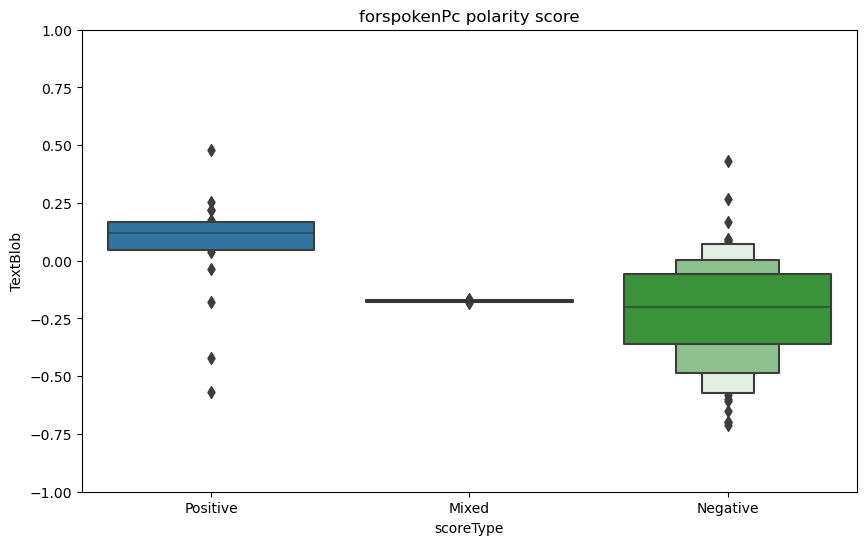

In [71]:
for game in games: # Comparison between sentiment detected and review type
    plt.figure(figsize=(10,6))
    plt.ylim([-1,1])
    plt.title(f'{game["name"]} polarity score')
    sns.boxenplot(x='scoreType', y='TextBlob', data=userReviews[game["name"]])
    plt.show();

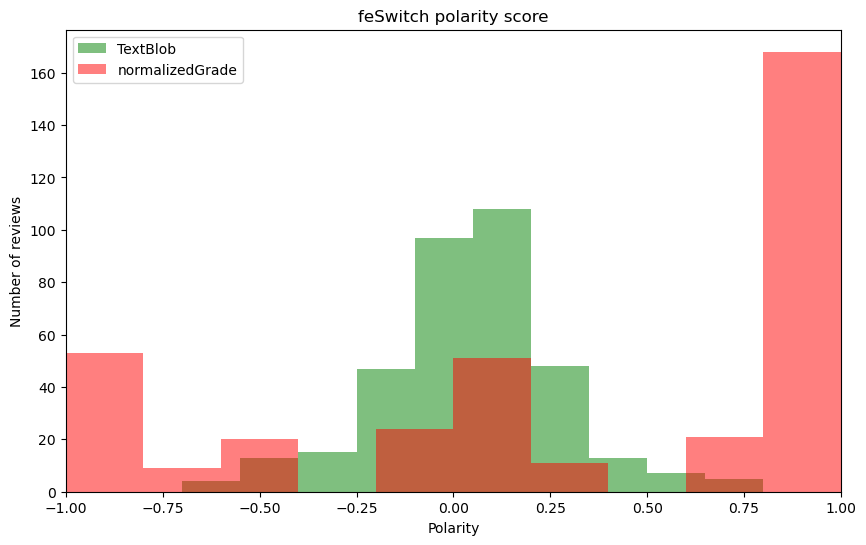

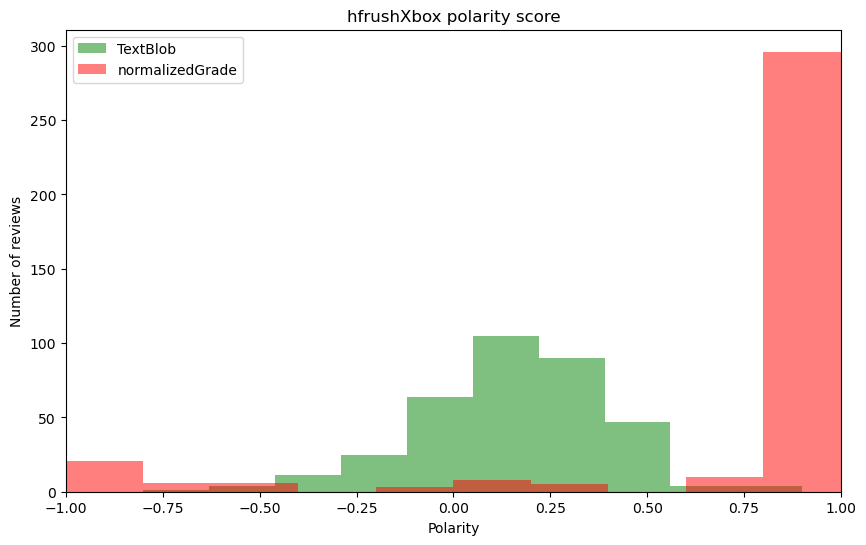

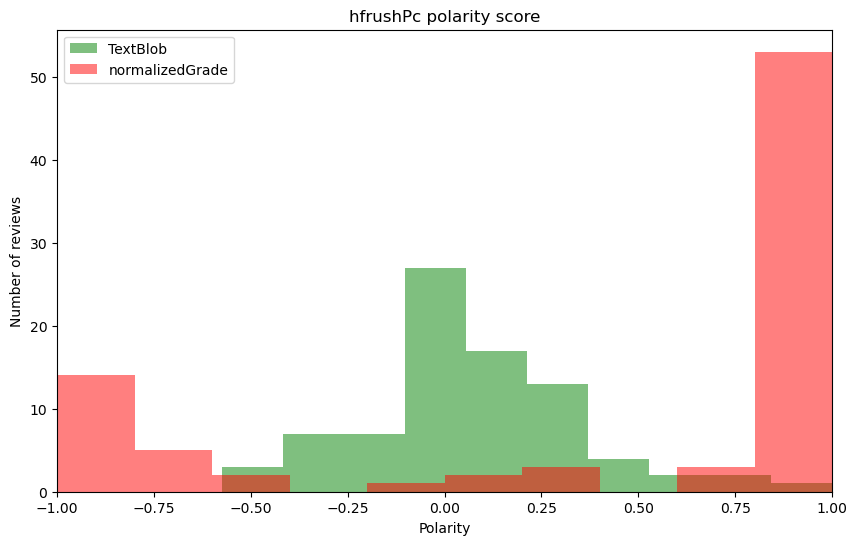

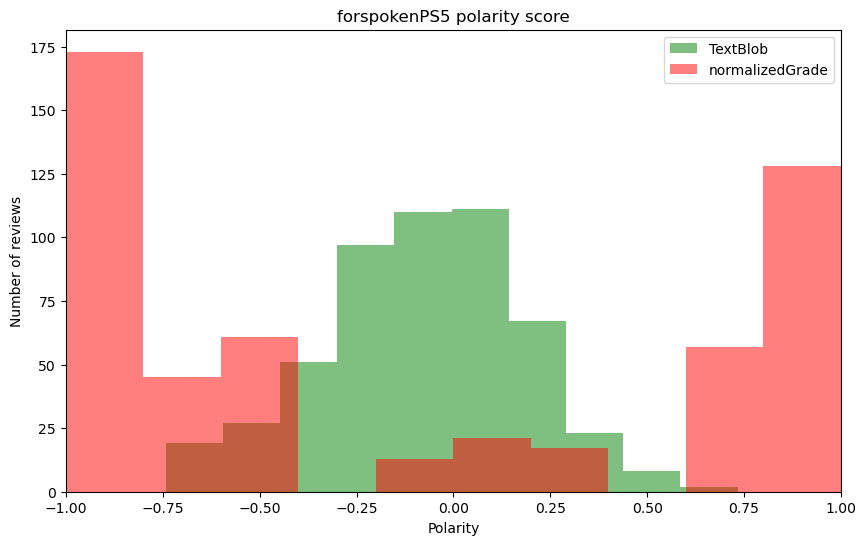

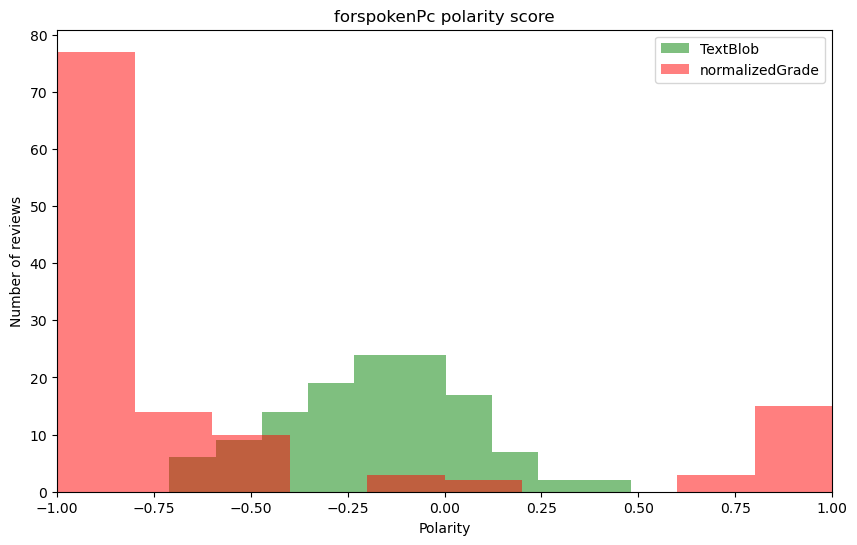

In [72]:
for game in games:
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(userReviews[game["name"]].TextBlob, facecolor='green', alpha=0.5, label='TextBlob')
    n, bins, patches = plt.hist(userReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

##### Helpfulness

In the case of the user reviews, we have an additional metric to evaluate them: **helpfulness**. It let other user to say whether the given review has some kind of relevance/utility. We will compare this indicator to the polarity of the reviews, both the ratio of positive interactions with respect to the total amount of interactions as well as just the number of interactions given by the community. 

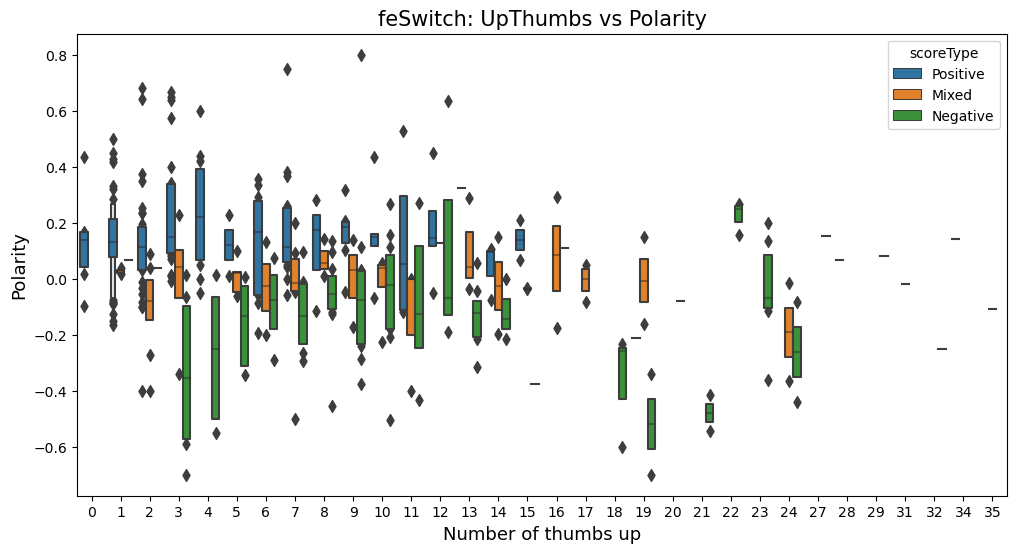

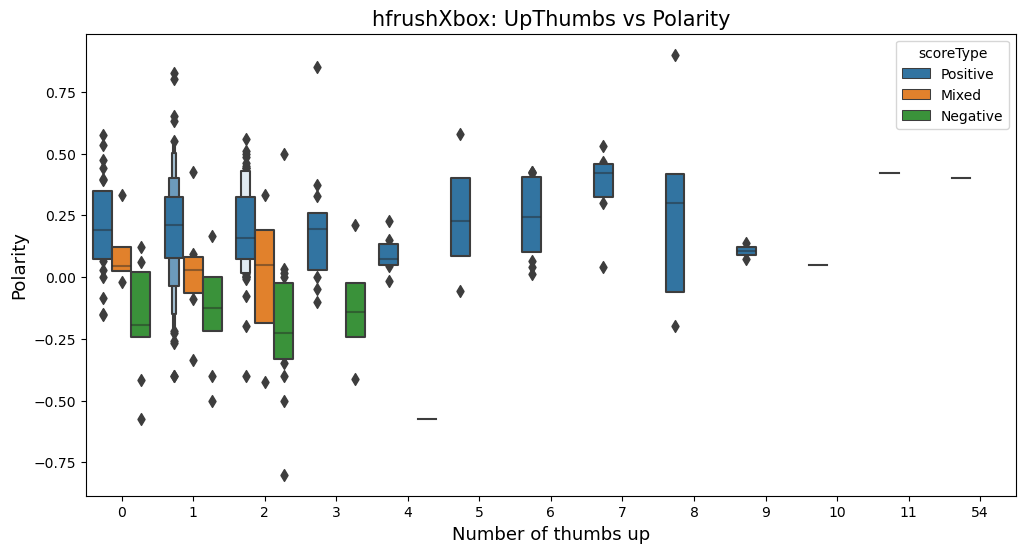

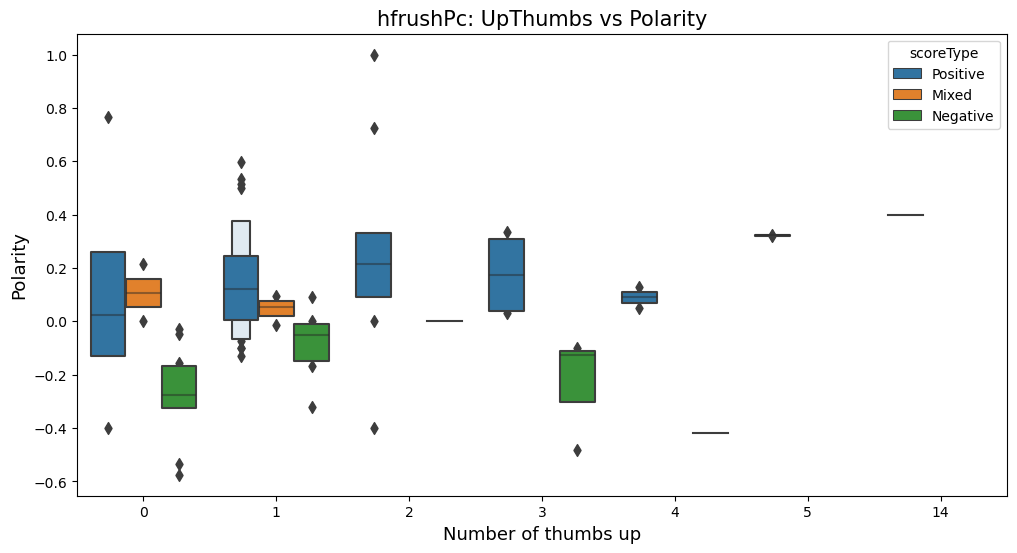

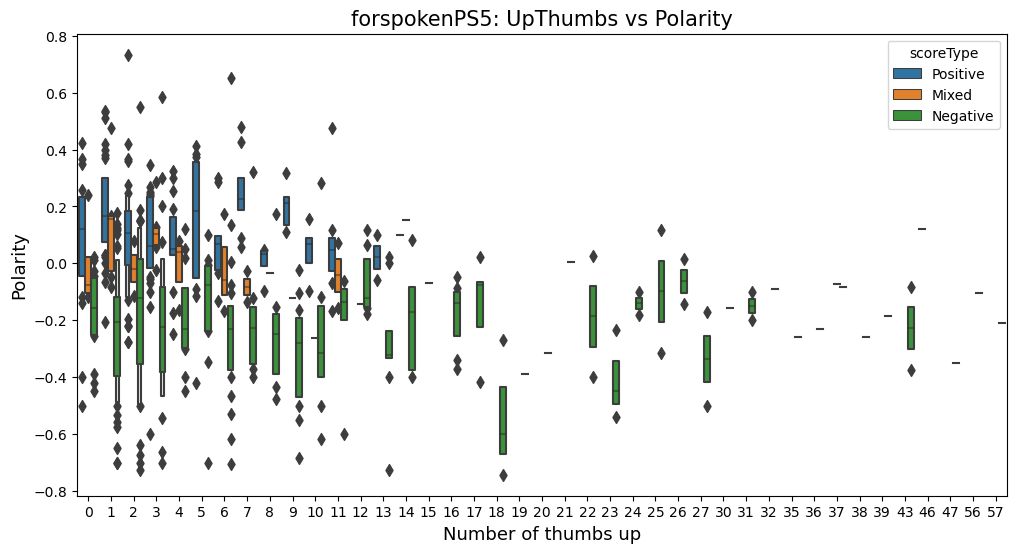

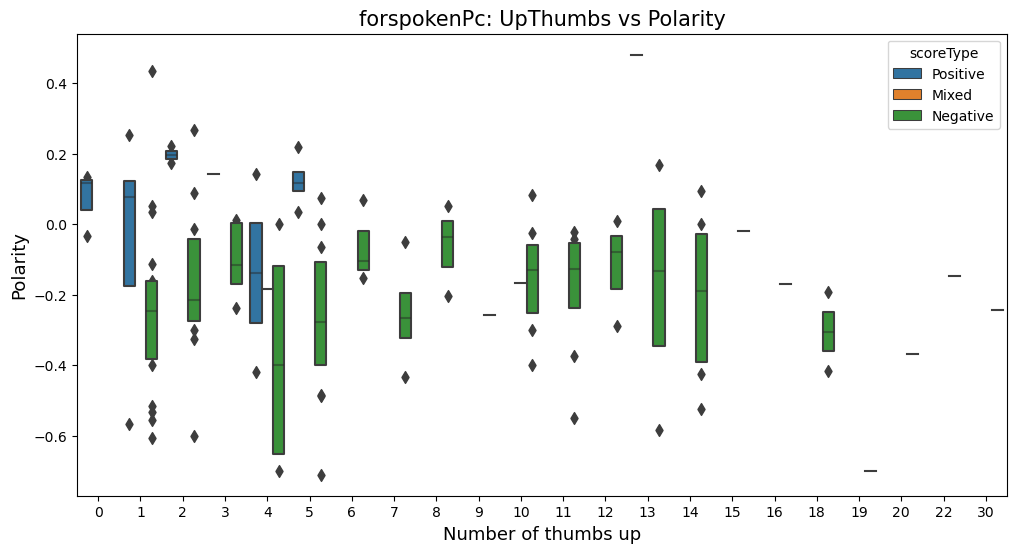

In [73]:
for game in games: # Consider only upThumbs instead of ratio
    plt.figure(figsize=(12,6))
    sns.boxenplot(x='upThumbs', y='TextBlob', hue='scoreType', data=userReviews[game["name"]])
    plt.xlabel('Number of thumbs up', fontsize=13)
    plt.ylabel('Polarity', fontsize=13)
    plt.title(f'{game["name"]}: UpThumbs vs Polarity', fontsize=15)
    plt.show();

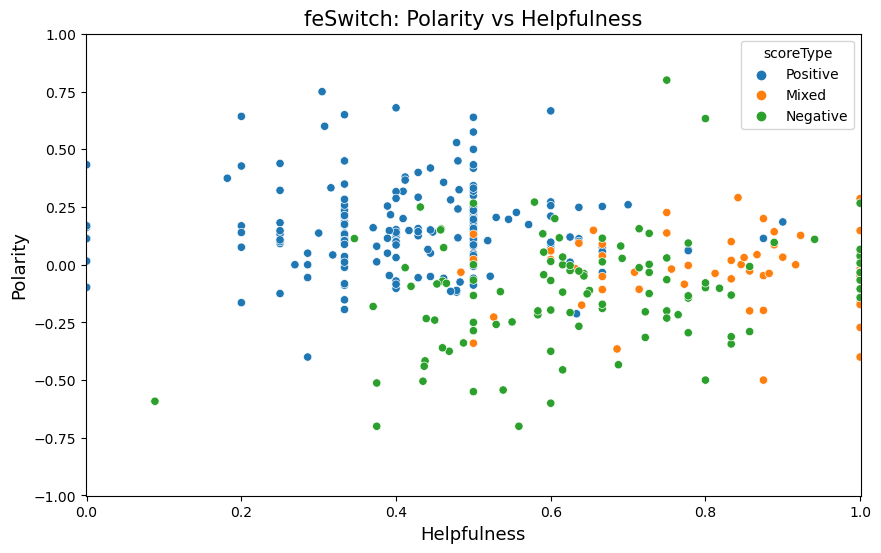

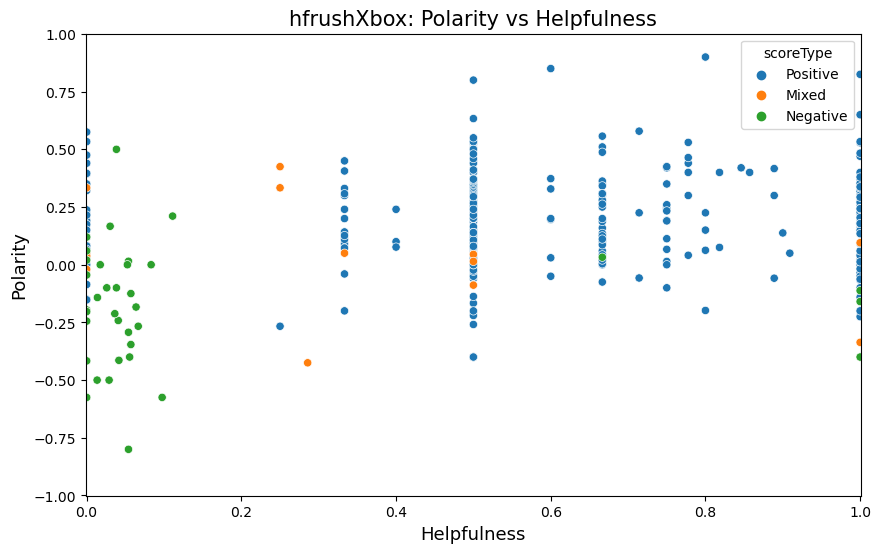

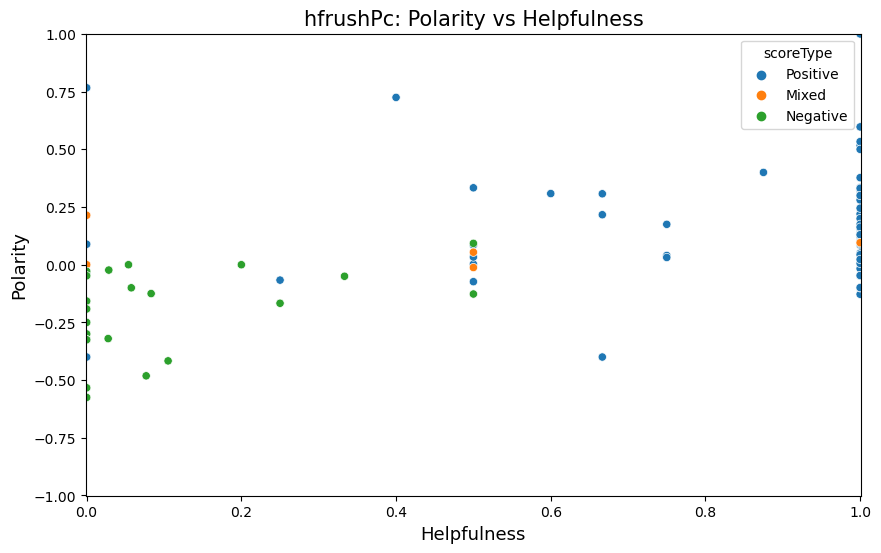

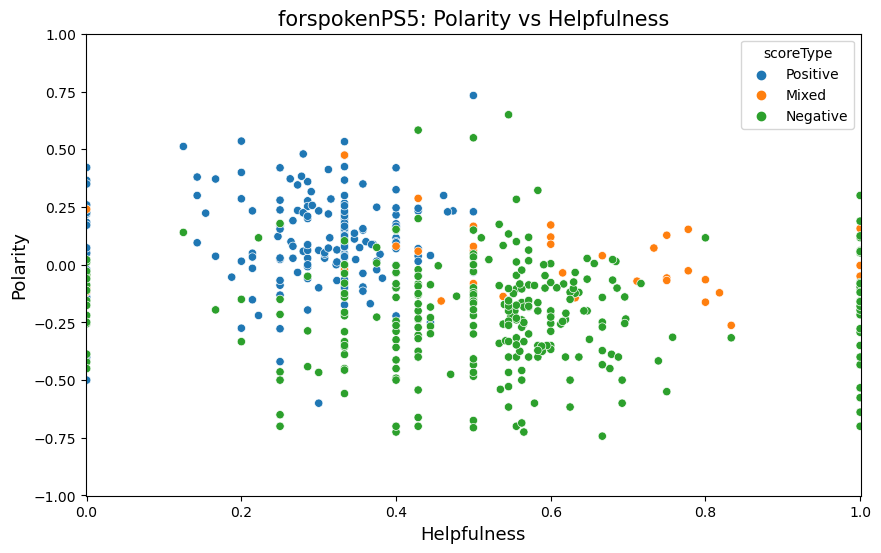

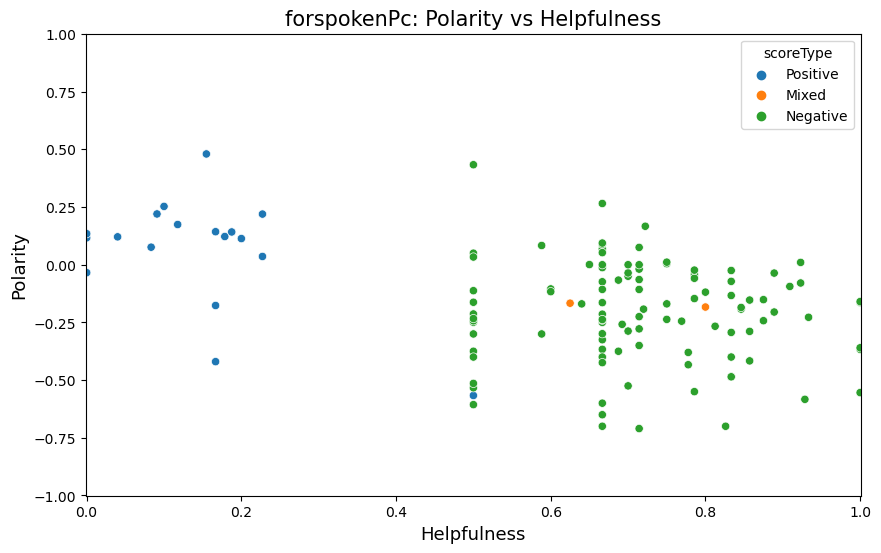

In [74]:
for game in games: # Polarity vs Helpfulness
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='helpfulness', y='TextBlob', hue="scoreType", data=userReviews[game["name"]])
    plt.xlim([-0.001,1.001])
    plt.xlabel('Helpfulness', fontsize=13)
    plt.ylim([-1.001,1.001])
    plt.ylabel('Polarity', fontsize=13)
    plt.title(f'{game["name"]}: Polarity vs Helpfulness', fontsize=15)
    plt.show();

#### Graph comparison

Once we have the polarity for both models, we can compare all of them in the same diagram. As expected, VADER clearly outperforms TextBlob since this last one is a much simpler model that tends to classify the text in neutral values, not being able to detect highly polarized sentiment in texts.

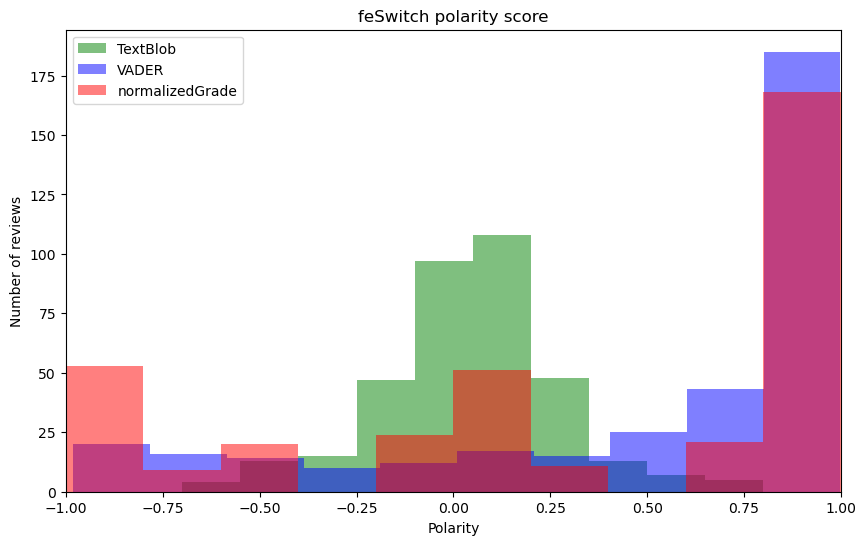

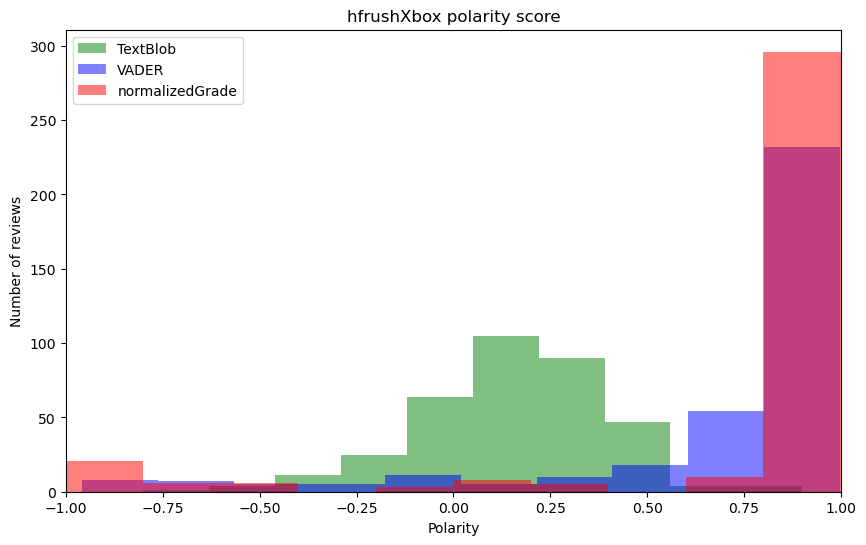

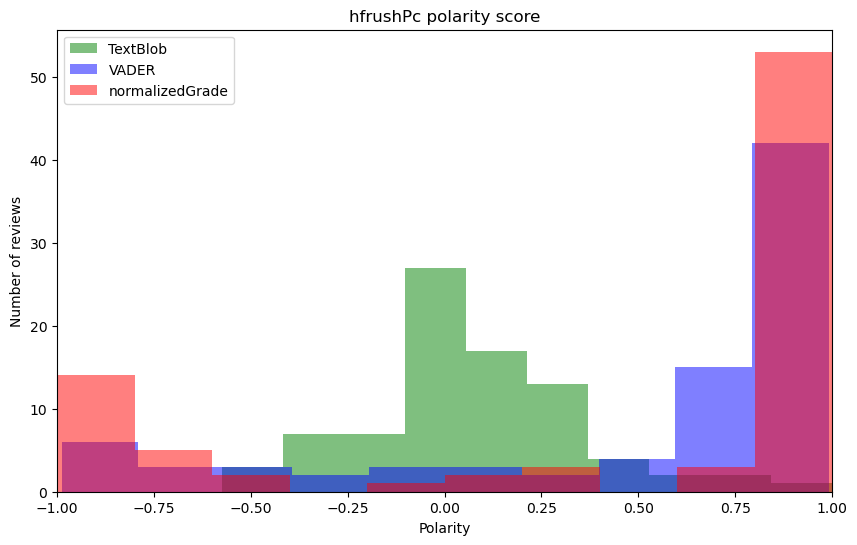

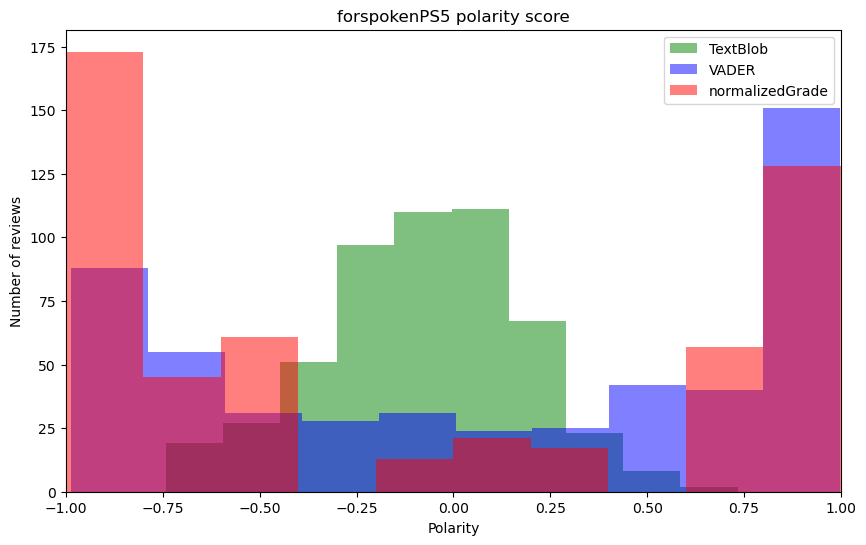

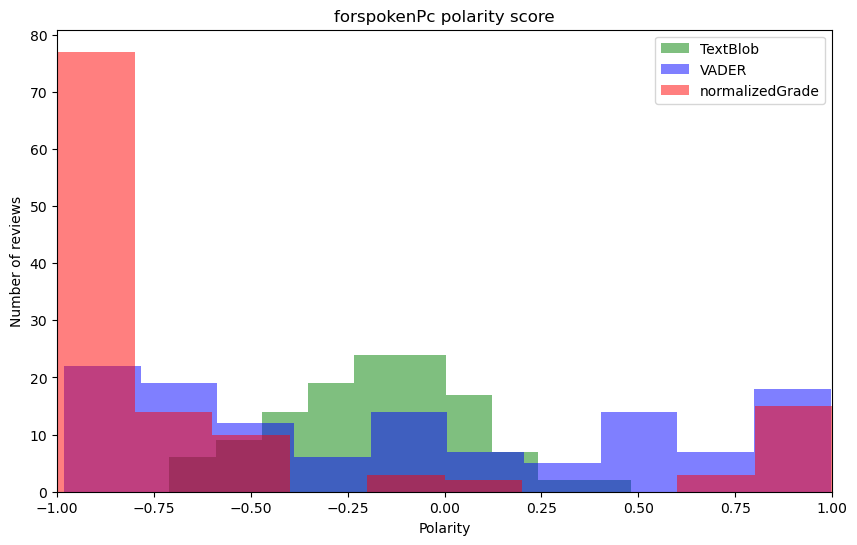

In [75]:
for game in games:
    plt.figure(figsize=(10,6))
    n, bins, patches = plt.hist(userReviews[game["name"]].TextBlob, facecolor='green', alpha=0.5, label='TextBlob')
    n, bins, patches = plt.hist(userReviews[game["name"]].VADER, facecolor='blue', alpha=0.5, label='VADER')
    n, bins, patches = plt.hist(userReviews[game["name"]].normalizedGrade, facecolor='red', alpha=0.5, label='normalizedGrade')
    plt.xlim([-1,1])
    plt.xlabel('Polarity')
    plt.ylabel('Number of reviews')
    plt.title(f'{game["name"]} polarity score')
    plt.legend()
    plt.show();

### Subjectivity

**Subjectivity** is used to determine whether the analyzed text expresses an opinion or not. Obviously, all the texts that we are gonna analyze here are reviews from videogames, which imply a high degree of subjectivity. However, we would like to know if a certain degree of subjectivity also implies connotations with respect to the polarity in the text or the grade given.

Given the previous two models, only *TextBlob* let us extract the sentiment of the text, so that is the one that we are going to use. Mathematically, subjectivity is a float that lies in the range of \[0,1\]. the higher the value, the closer to an opinion is the text considered.

In [76]:
for game in games: # Calculate subjectivity for each game
    userReviews[game["name"]]['subjectivity'] = userReviews[game["name"]].lemmatizedText.apply(lambda x: TextBlob(x).sentiment.subjectivity)

C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\barri\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

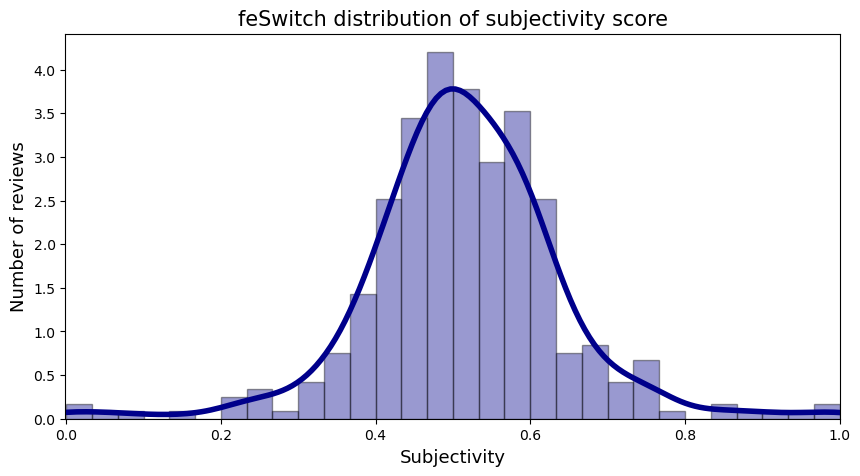

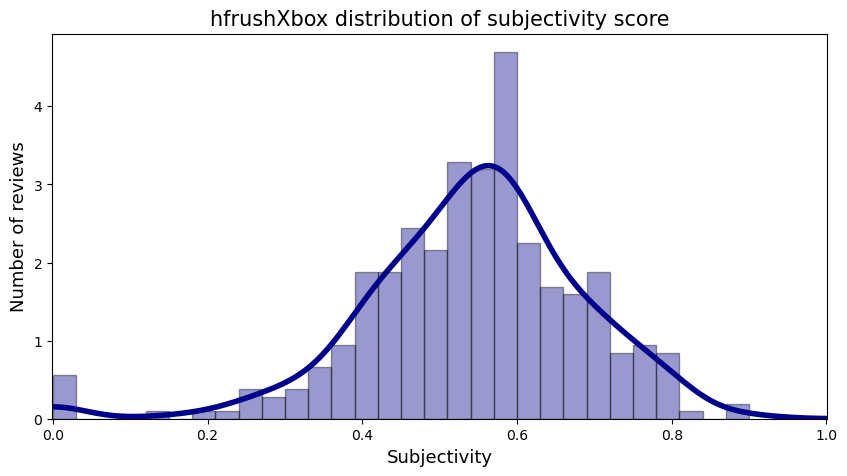

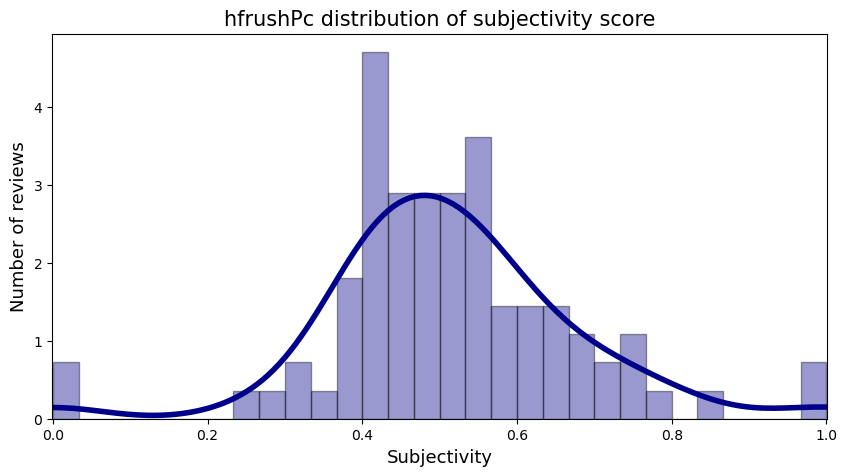

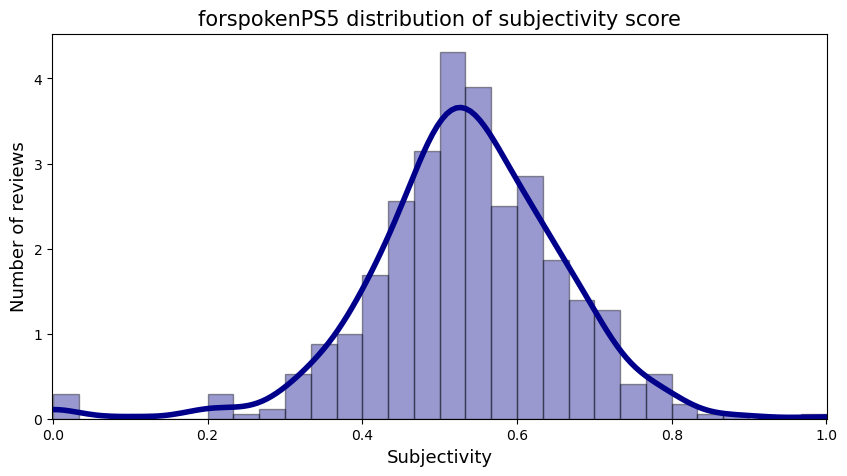

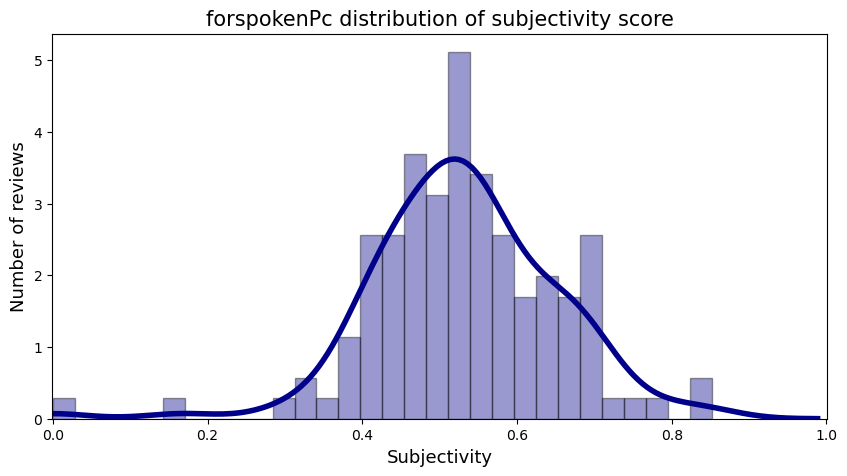

In [77]:
for game in games: # Density plot and histogram of subjectivity
    plt.figure(figsize=(10,5))
    sns.distplot(userReviews[game["name"]]['subjectivity'], hist=True, kde=True, bins=int(30), color = 'darkblue', hist_kws={'edgecolor':'black'}, kde_kws={'linewidth': 4})
    plt.xlim([-0.001,1.001])
    plt.xlabel('Subjectivity', fontsize=13)
    plt.ylabel('Number of reviews', fontsize=13)
    plt.title(f'{game["name"]} distribution of subjectivity score', fontsize=15)

Besides from this plot, we can also analize the influence of subjectivity in the polarity detected. In order to get a better understanding of the data, we can also group the reviews based on the ccategory of each review.

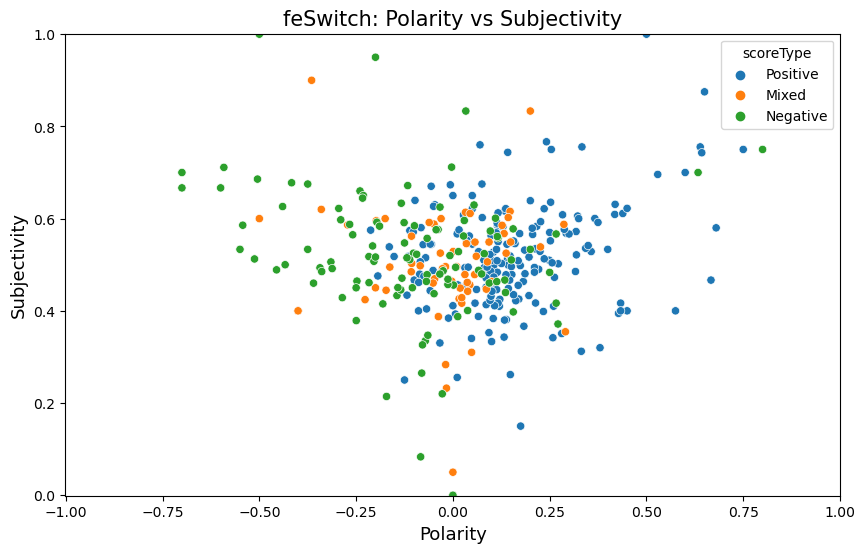

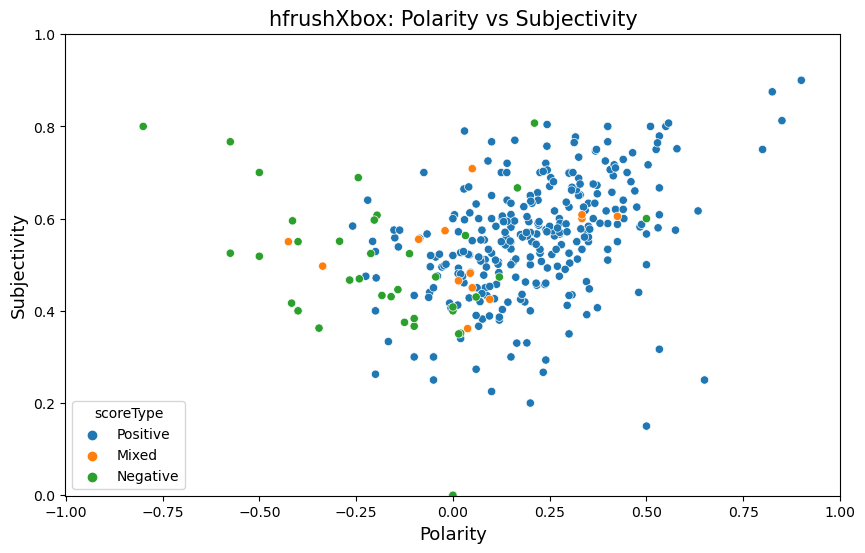

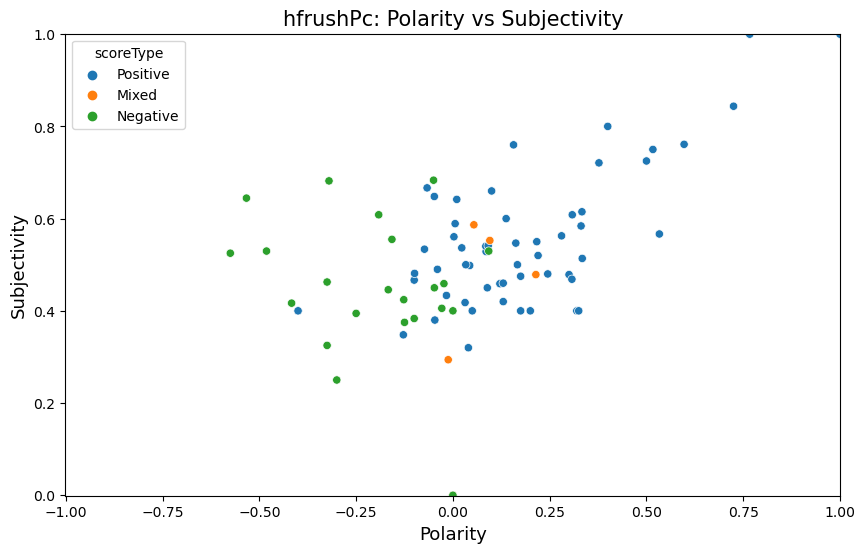

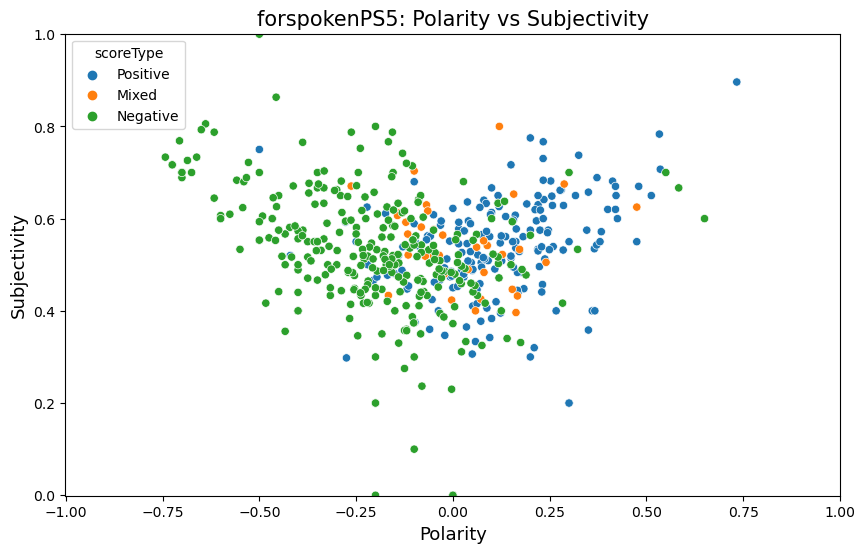

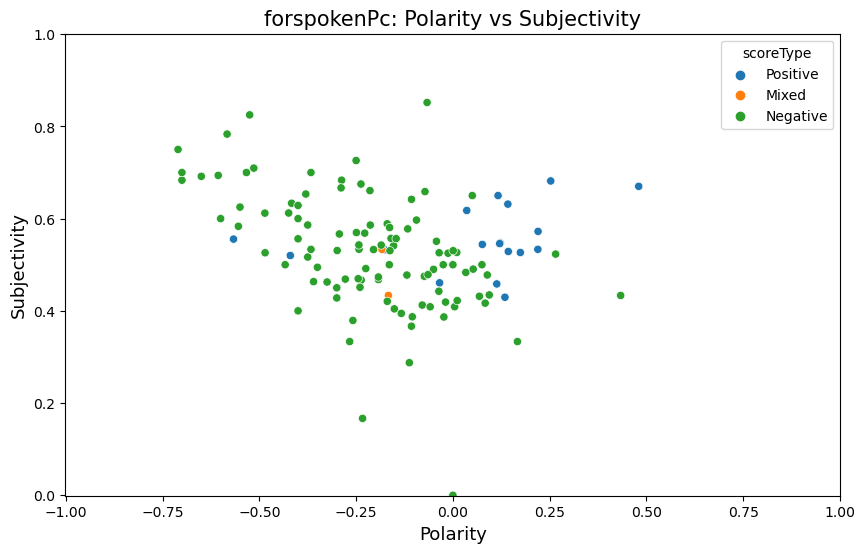

In [78]:
for game in games: # Polarity vs subjectivity
    plt.figure(figsize=(10,6))
    sns.scatterplot(x='TextBlob', y='subjectivity', hue="scoreType", data=userReviews[game["name"]])
    plt.xlim([-1.001,1.001])
    plt.xlabel('Polarity', fontsize=13)
    plt.ylim([-0.001,1.001])
    plt.ylabel('Subjectivity', fontsize=13)
    plt.title(f'{game["name"]}: Polarity vs Subjectivity', fontsize=15)
    plt.show();

### Customized model

Sentiment is trained using sentiment classifiers. So far, we have only used pretrained classifiers that are trained on general texts. In this section, we will also train our own classifier in order to identify whether a review is positive, negative or mixed. We perform this over reviews since all the data is already labeled so the training of the models can be easily done.

#### Train and test data

We need to split the data in two datasets: one for training the data (which is recommended to be between 80%-60% of all the data) and another one for testing the created model (20%-40% of the data). We also need to vectorize the data, as we keep as a unique string.

In [79]:
# Select features and labels
X = allUserReviews['lemmatizedText']
Y = allUserReviews['scoreType']
# Create train and test datasets (70/30) stratified
train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.3, random_state=13, stratify=Y)

In [80]:
# Creating the model. Parameters:
# min_df discards words appearing in less than min_df documents
# max_df discards words appearing in more than max_df% of the documents
# sublinear_tf usage of sublinear weighting (scale the term frequency in logarithmic scale)
# use_idf enables/disables the inverse document frequency
vectorizer = TfidfVectorizer(min_df=5, max_df=0.8, sublinear_tf=True, use_idf=True)

In [81]:
# Vectorize the texts
train_vectors = vectorizer.fit_transform(train_X)
test_vectors = vectorizer.transform(test_X)

#### Model training

We can finally check how well our model performed. We see that we have reached an accuracy of 80%. As expected, the reesults are better than compared to the critic's reviews case since we have almost the triple amount of data.

In [82]:
# Train the model
nb = MultinomialNB()
nb.fit(train_vectors, train_Y).score(test_vectors, test_Y)

0.8120649651972158

#### Model evaluation

Eventually, we will analyze the results obtained in terms of different scores. After that, we will perform the so called **cross-validation** in order to improve the accuracy of the model.

In [83]:
print("Multinomial Naive Bayes classifier")
print(classification_report(test_Y, nb.predict(test_vectors)))
predicted = cross_val_predict(nb, train_vectors, train_Y, cv=10)
print("Cross validation: %s" % accuracy_score(train_Y, predicted))

Multinomial Naive Bayes classifier
              precision    recall  f1-score   support

       Mixed       0.00      0.00      0.00        36
    Negative       0.85      0.79      0.82       168
    Positive       0.79      0.96      0.86       227

    accuracy                           0.81       431
   macro avg       0.55      0.58      0.56       431
weighted avg       0.75      0.81      0.78       431

Cross validation: 0.8075772681954138


C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\barri\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


We will also show a **confusion matrix** that let us see more clearly the number of true/false positives/negatives that we have predicted.

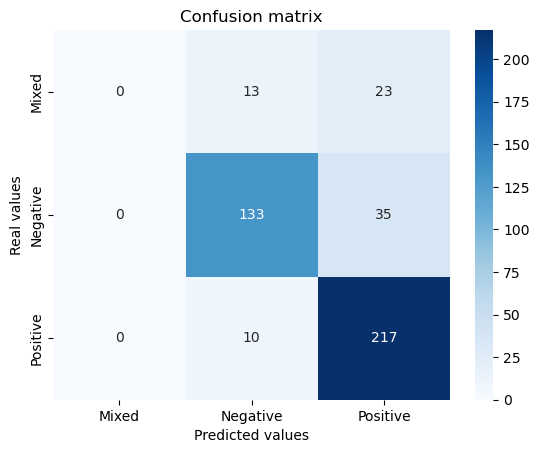

In [84]:
from pandas import DataFrame

confm = confusion_matrix(test_Y, nb.predict(test_vectors))
plt.figure()
df_cm = DataFrame(confm, index=['Mixed', 'Negative', 'Positive'], columns=['Mixed', 'Negative', 'Positive'])
ax = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt='d')
plt.xlabel('Predicted values')
plt.ylabel('Real values')
plt.title('Confusion matrix')
print('')

#### Model saving

To conclude, we will just save the model in case that we want to use it in the future.

In [85]:
import pickle as pkl

filepath = f'Modelos/sentiment/userReviews.pkl'
with open(filepath, "wb") as file:
    pkl.dump(nb, file)

With this, we conclude the implementation of the project and it only last to further analyze the results, which can be seen in the [project report](report.pdf).